# Policy Gradient-TensorFlow

Here we use the `TensorFlow2.0` to implement policy gradient and play `MountainCar` game.

# Implementation of policy gradient using TensorFlow-2.0

Policy gradient is a basic algorithm of Reinforcement Learning (RL) that can be adopted in continuous or discrete problems. It can be found somewhere in several advanced RL algorithms such as A2C, A3C, and so on.

# Theory

Policy gradient algorithm trains a policy to play a game. A policy is a function that inputs states and outputs the probability of every action:

$
p(a|s) = \pi(a|s)
$

, where $s \in \mathcal{S}$ is a given state and $a \in \mathcal{A}$ is an action. We can use a neural network to construct our policy.

The goal of a policy is to maximize the ***expected cumulated reward***. In every episode a policy would receive a series of rewards, and we can define the total cumulated reward as:

$
R_\theta = \sum^T_{t=1} r_t
$

where $\theta$ indicates the parameters of the neural neywork. Then the expected cumulated reward is given by

$
\bar{R}_\theta = \mathbb{E}[R_\theta] = \sum_\tau R(\tau)P(\tau|\theta)
$

where $\tau$ denotes the “trajectory” of an episode:
$\tau = \left\{ s_1, a_1, r_1, s_2, a_2, r_2, \cdots, s_T, a_T, r_T \right\}$.

So the goal becomes to find the best parameters $\theta$ in order to maximize $\bar{R}_\theta$:

$
\theta^* = \arg \max_\theta \bar{R}_\theta
$

Therefore, we can use ***gradient ascent*** to update the parameters $\theta$:

$
\theta_{t+1} = \theta_t + \eta \nabla \bar{R}_{\theta_t}
$

Next, we write $\nabla \bar{R}_\theta$ explicitly:

$
\nabla \bar{R}_\theta
= \nabla \sum_\tau R(\tau) P(\tau|\theta) \\
= \sum_\tau R(\tau) \nabla P(\tau|\theta) \\
= \sum_\tau R(\tau) P(\tau|\theta) \frac{\nabla P(\tau|\theta)}{P(\tau|\theta)} \\
= \sum_\tau R(\tau) P(\tau|\theta) \nabla \ln P(\tau|\theta) \\
\approx \frac{1}{N} \sum_\tau R(\tau) \nabla \ln P(\tau|\theta)
$

, if there are $N$ episodes.

Then we rewrite $P(\tau|\theta)$ as the product of transition probabilities and action probabilities that the policy produces:

$
P(\tau|\theta)
= p(s_1) \times \pi(a_1|s_1;\theta) \times p(r_1,s_2|s_1,a_1) \times \pi(a_2|s_2;\theta) \times \cdots \\
= p(s_1) \prod^T_{t=1} \pi(a_t|s_t;\theta) p(r_t,s_{t+1}|s_t,a_t) \\
\ln P(\tau|\theta) = \ln p(s_1) + \sum^T_{t=1} \ln \pi(a_t|s_t;\theta) + \ln p(r_t,s_{t+1}|s_t,a_t)
$

So

$
\nabla \ln P(\tau|\theta) = \sum^T_{t=1} \nabla \ln \pi(a_t|s_t;\theta)
$

Substitude the result back and we get

$
\nabla \bar{R}_\theta
\approx \frac{1}{N} \sum_\tau R(\tau) \nabla \ln P(\tau|\theta) \\
\approx \frac{1}{N} \sum_\tau \sum^{T_\tau}_{t=1} R(\tau) \nabla \ln \pi(a_t|s_t;\theta)
$

# Details of Implementation

1. Although the gradients come from the data of $N$ episodes, in the implementation we update the parameters every episode for simplicity while it works well.
2. Rather than using the total reward $R(\tau) = \sum^T_{t=1} r_t$, we use a constant $\gamma$ which is called the discount rate

### 1. Import Labraries

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline

/Users/william/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 2. Define a class to store memory for training

This memory can store an experience $(state, action, reward)$ for training after episode is completed.

In [2]:
class Memory:
    
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        
    def store(self, s, a, r):
        self.states.append(s)
        self.actions.append(a)
        self.rewards.append(r)
    
    def withdraw(self):
        return self.states, self.actions, self.rewards
        
    def clear(self):
        self.states = []
        self.actions = []
        self.rewards = []

### 3. Define a class for policy gradient

In [3]:
class PolicyGradient:
    
    def __init__(self,
                 n_actions,
                 n_features,
                 learning_rate=0.001,
                 discount=0.9
                ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = discount
        self.memory = Memory()
        
        self._build_model()
        
    def _build_model(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(16, activation='relu',
                                             input_shape=(self.n_features,)))
        self.model.add(tf.keras.layers.Dense(16, activation='relu'))
        self.model.add(tf.keras.layers.Dense(self.n_actions, activation=None))
        
        self.optimizer = tf.keras.optimizers.Adam(self.lr)
        
    def _process_rewards(self, rewards):
        processed_rewards = np.zeros_like(rewards, dtype=np.float32)
        
        G = 0
        for t in reversed(range(len(rewards))):
            G = rewards[t] + self.gamma * G
            processed_rewards[t] = G
            
        processed_rewards -= np.mean(processed_rewards)
        processed_rewards /= np.std(processed_rewards)
        
        return tf.convert_to_tensor(processed_rewards)
    
    def _grad(self, states, actions, rewards):
        with tf.GradientTape() as tape:
            loss_value = self._loss(states, actions, rewards)
        return tape.gradient(loss_value, self.model.trainable_variables)
        
    def _loss(self, states, actions, rewards):
        states = tf.convert_to_tensor(states)
        
        logits_actions = self.model(states)  # can not use self.model.predict(states)
        labels_actions = tf.convert_to_tensor(actions)
        modify_rewards = self._process_rewards(rewards)
        
        neg_log_prob = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=actions ,logits=logits_actions)
        
        return tf.reduce_mean(modify_rewards * neg_log_prob)
        
    def store(self, state, action, reward):
        self.memory.store(state, action, reward)
    
    def choose_action(self, state):
        state = np.expand_dims(state, axis=0)
        probs = self.model.predict(state)  # (1, n_actions)
        probs = np.exp(probs)  # (1, n_actions)
        probs /= np.sum(probs)
        action = np.random.choice(self.n_actions, p=probs.ravel())
        
        return action
    
    def learn(self):
        states, actions, rewards = self.memory.withdraw()
        
        grads = self._grad(states, actions, rewards)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        
        self.memory.clear()
        
    def save(self, path):
        self.model.save_weights(path)
        print('Saved!')
        
    def restore(self, path):
        self.model.load_weights(path)
        print('Loaded!')

### 4. Let's train an actor!

##### 4.1 Create an environment

In [4]:
env = gym.make('MountainCar-v0')
state = env.reset()
state

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/Users/william/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


array([-0.53731876,  0.        ])

##### 4.2 Create an actor

In [5]:
actor = PolicyGradient(n_actions=env.action_space.n, n_features=len(state), discount=0.9)

##### 4.3 Custom rewards

Since the reward for mountain car is sparse. And we know that sparse reward may lead difficult training since actor has no direction to learn.

Instead of sparse reward, we define our custom reward that appears more frequently in order to train our actor fast. Our custom reward is defined in the way so that more fast the car is, and more right position the car can reach, more high the reward is.

In [6]:
def modify_reward(state):
    x, v = state
    
    reward = 50 * v**2
    
    if x > 0.20:
        reward += 1
    if x > 0.30:
        reward += 1
    if x > 0.40:
        reward += 1
    if x > 0.45:
        reward += 1
            
    return reward

##### 4.4 Train the actor

In [7]:
step = 0
periods = []
rewards = []

for episode in range(5000):
    period = 0
    total_reward = 0
    
    state = env.reset()
    
    while True:
        env.render()
        
        action = actor.choose_action(state)
        next_state, reward, done, info = env.step(action)
        reward = modify_reward(state)
        
        total_reward += reward
        
        actor.store(state, action, reward)
        
        state = next_state
        
        if done:
            actor.learn()
            break
            
        step += 1
        period += 1
    
    if episode % 10 == 0:
        print('Episode: {:3d}, period: {:3d}, reward: {:3.3f}'.format(episode, period, total_reward))
    rewards.append(total_reward)

print('game over')

Episode:   0, period: 199, reward: 0.089
Episode:  10, period: 199, reward: 0.433
Episode:  20, period: 199, reward: 1.428
Episode:  30, period: 199, reward: 0.800
Episode:  40, period: 199, reward: 0.833
Episode:  50, period: 199, reward: 0.337
Episode:  60, period: 199, reward: 0.191
Episode:  70, period: 199, reward: 1.820
Episode:  80, period: 199, reward: 0.478
Episode:  90, period: 199, reward: 0.211
Episode: 100, period: 199, reward: 0.153
Episode: 110, period: 199, reward: 0.291
Episode: 120, period: 199, reward: 0.449
Episode: 130, period: 199, reward: 0.555
Episode: 140, period: 199, reward: 0.654
Episode: 150, period: 199, reward: 0.710
Episode: 160, period: 199, reward: 0.160
Episode: 170, period: 199, reward: 0.078
Episode: 180, period: 199, reward: 0.178
Episode: 190, period: 199, reward: 0.272
Episode: 200, period: 199, reward: 0.360
Episode: 210, period: 199, reward: 0.219
Episode: 220, period: 199, reward: 1.885
Episode: 230, period: 199, reward: 0.088
Episode: 240, pe

Episode: 1980, period: 199, reward: 1.129
Episode: 1990, period: 199, reward: 0.475
Episode: 2000, period: 199, reward: 1.009
Episode: 2010, period: 199, reward: 2.226
Episode: 2020, period: 199, reward: 0.839
Episode: 2030, period: 199, reward: 1.337
Episode: 2040, period: 199, reward: 0.403
Episode: 2050, period: 199, reward: 0.997
Episode: 2060, period: 199, reward: 0.344
Episode: 2070, period: 199, reward: 0.072
Episode: 2080, period: 199, reward: 1.062
Episode: 2090, period: 199, reward: 0.589
Episode: 2100, period: 199, reward: 1.472
Episode: 2110, period: 199, reward: 1.138
Episode: 2120, period: 199, reward: 1.198
Episode: 2130, period: 199, reward: 0.728
Episode: 2140, period: 199, reward: 2.804
Episode: 2150, period: 199, reward: 2.556
Episode: 2160, period: 199, reward: 1.155
Episode: 2170, period: 199, reward: 4.159
Episode: 2180, period: 199, reward: 1.023
Episode: 2190, period: 199, reward: 2.249
Episode: 2200, period: 199, reward: 2.009
Episode: 2210, period: 199, reward

Episode: 3930, period: 199, reward: 7.318
Episode: 3940, period: 199, reward: 7.370
Episode: 3950, period: 199, reward: 2.194
Episode: 3960, period: 199, reward: 3.792
Episode: 3970, period: 199, reward: 5.441
Episode: 3980, period: 174, reward: 35.831
Episode: 3990, period: 199, reward: 3.453
Episode: 4000, period: 199, reward: 2.063
Episode: 4010, period: 199, reward: 3.584
Episode: 4020, period: 176, reward: 31.332
Episode: 4030, period: 199, reward: 3.547
Episode: 4040, period: 199, reward: 7.051
Episode: 4050, period: 199, reward: 3.877
Episode: 4060, period: 199, reward: 14.756
Episode: 4070, period: 179, reward: 39.015
Episode: 4080, period: 181, reward: 31.018
Episode: 4090, period: 199, reward: 0.903
Episode: 4100, period: 199, reward: 4.067
Episode: 4110, period: 199, reward: 4.425
Episode: 4120, period: 199, reward: 10.826
Episode: 4130, period: 199, reward: 2.635
Episode: 4140, period: 182, reward: 33.595
Episode: 4150, period: 199, reward: 3.765
Episode: 4160, period: 199,

##### 4.5 Save the model

In [8]:
actor.save(path='model.ckpt')

Saved!


##### 4.5 Plot the reward

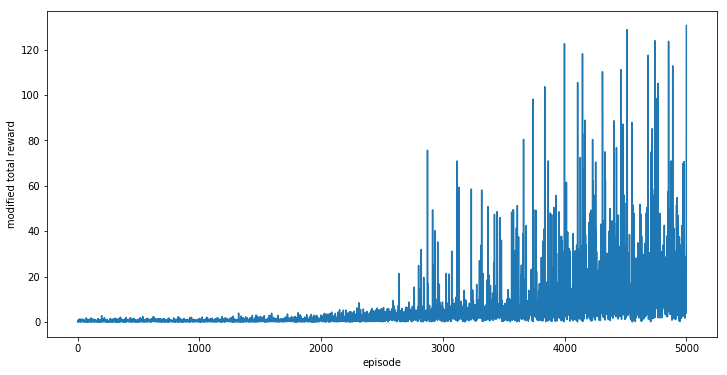

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(rewards, label='reward')
plt.xlabel('episode')
plt.ylabel('modified total reward');

### 5. Let's test our actor

##### 5.1 Restore the model

In [10]:
actor = PolicyGradient(n_actions=env.action_space.n, n_features=len(state), discount=0.9)
actor.restore('model.ckpt')

Loaded!


##### 5.2 run 100 episodes

In [13]:
rewards = []
total_frames = []

for episode in range(100):
    frames = []
    total_reward = 0
    
    state = env.reset()
    
    while True:
        frame = env.render(mode='rgb_array')
        frames.append(frame)
        
        action = actor.choose_action(state)
        state_next, reward, done, info = env.step(action)
        
        total_reward += reward
        
        state = state_next
        
        if done:
            break
    
    print('Episode: {:3d}, reward: {:3d}'.format(episode, int(total_reward)))
    total_frames.append(frames)
    rewards.append(total_reward)

print('game over')

Episode:   0, reward: -200
Episode:   1, reward: -200
Episode:   2, reward: -200
Episode:   3, reward: -171
Episode:   4, reward: -182
Episode:   5, reward: -198
Episode:   6, reward: -200
Episode:   7, reward: -165
Episode:   8, reward: -200
Episode:   9, reward: -200
Episode:  10, reward: -200
Episode:  11, reward: -200
Episode:  12, reward: -200
Episode:  13, reward: -200
Episode:  14, reward: -200
Episode:  15, reward: -174
Episode:  16, reward: -200
Episode:  17, reward: -184
Episode:  18, reward: -200
Episode:  19, reward: -200
Episode:  20, reward: -200
Episode:  21, reward: -200
Episode:  22, reward: -200
Episode:  23, reward: -200
Episode:  24, reward: -200
Episode:  25, reward: -200
Episode:  26, reward: -200
Episode:  27, reward: -200
Episode:  28, reward: -200
Episode:  29, reward: -200
Episode:  30, reward: -200
Episode:  31, reward: -200
Episode:  32, reward: -200
Episode:  33, reward: -143
Episode:  34, reward: -200
Episode:  35, reward: -176
Episode:  36, reward: -200
E

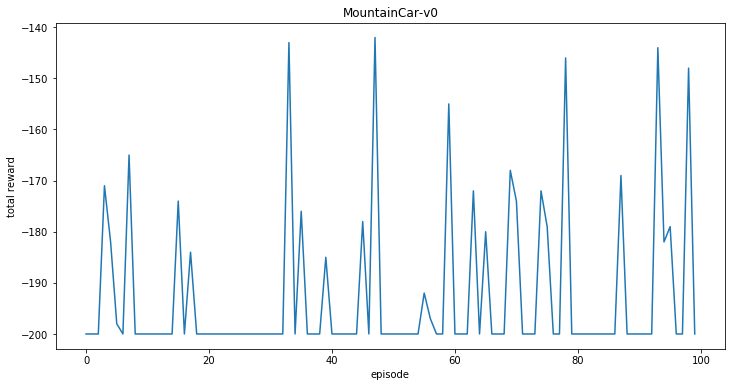

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(rewards, label='reward')
plt.xlabel('episode')
plt.ylabel('total reward')
plt.title('MountainCar-v0');

### 6. Let's generate an animation to show off

In [15]:
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display
from JSAnimation.IPython_display import display_animation
%matplotlib inline

In [23]:
# choose the best run
best_run = np.argmax(rewards)
frames = total_frames[best_run]

In [17]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))
    
    return anim

In [18]:
def save_animation(anim, savepath):
    assert savepath.endswith('.mp4')
    
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
    anim.save(savepath, writer=writer)
    
    print('Save animation completed')


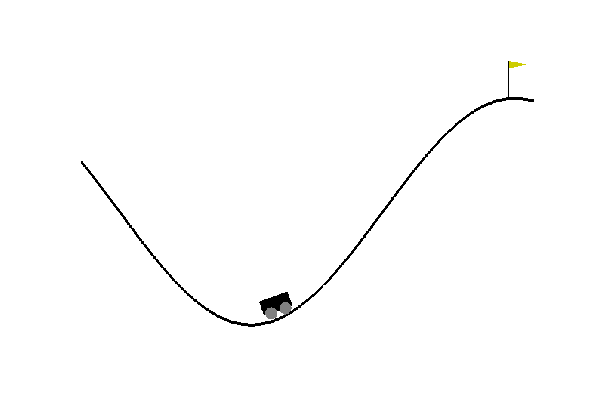
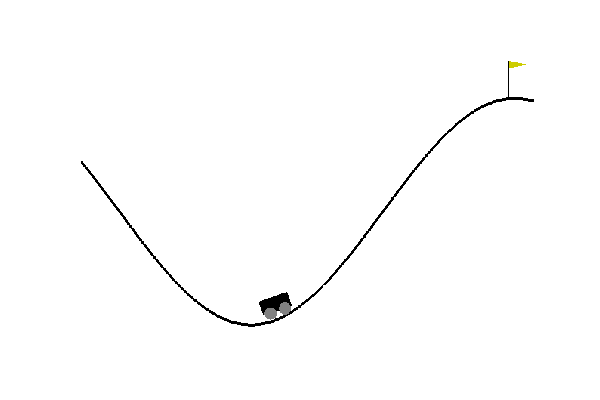
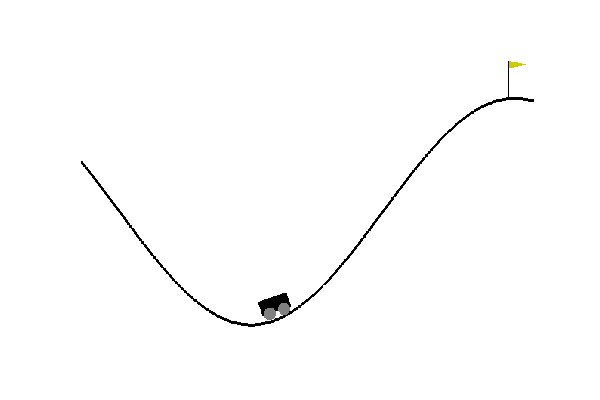
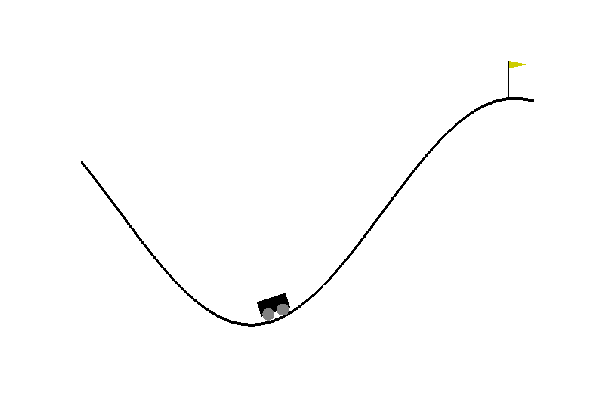
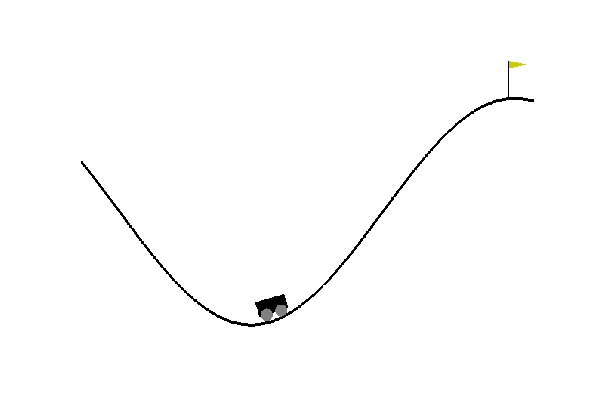
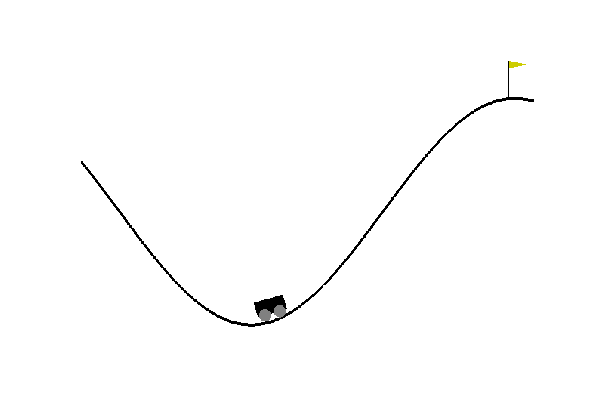
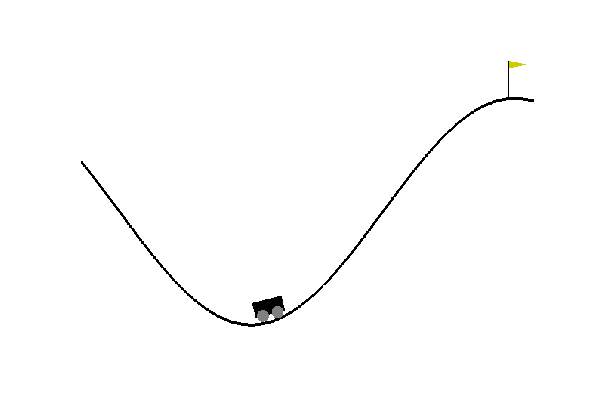
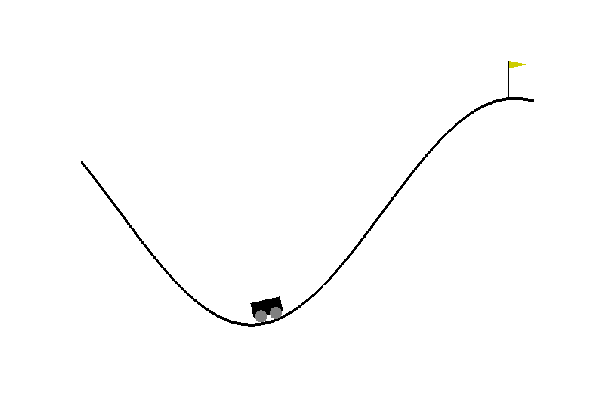
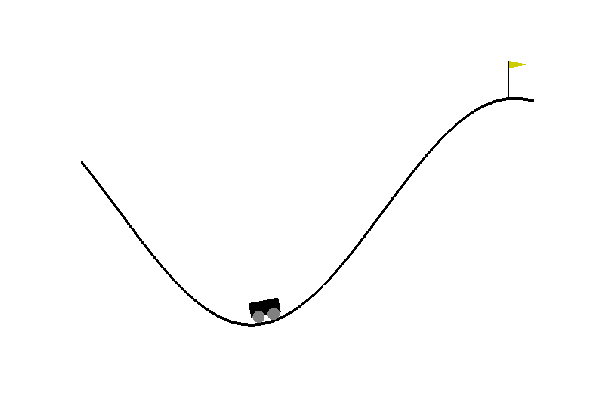
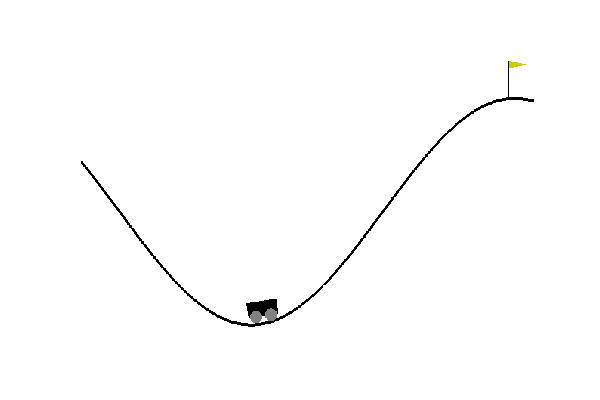
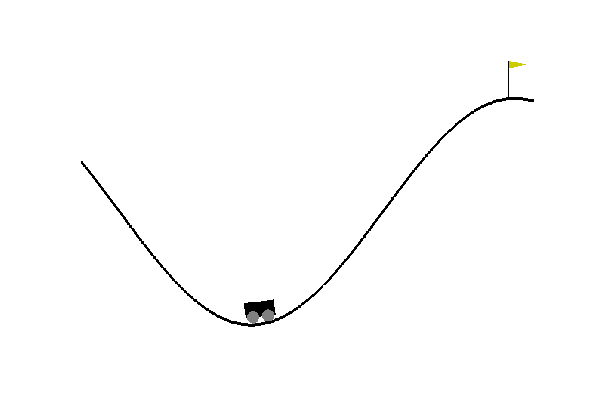
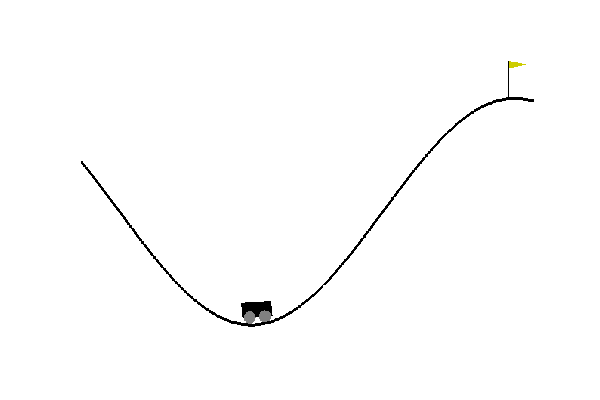
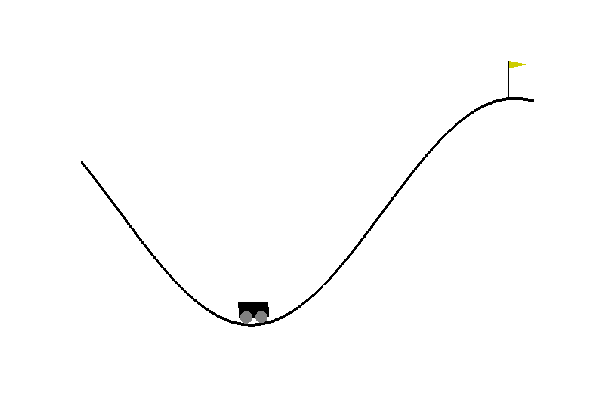
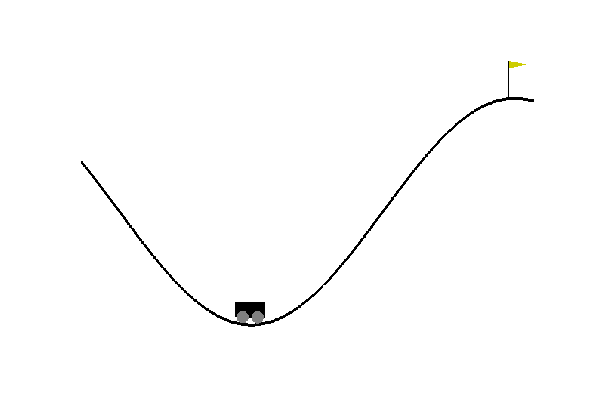
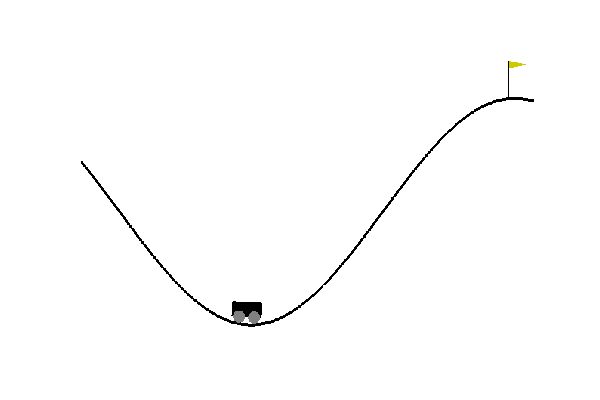
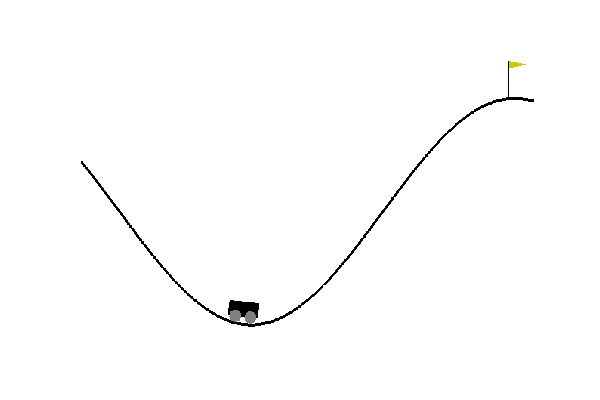
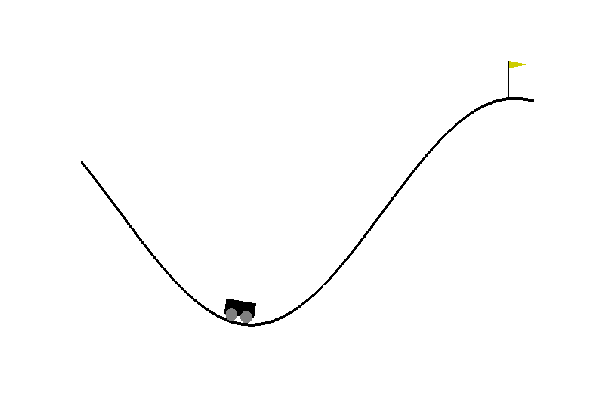
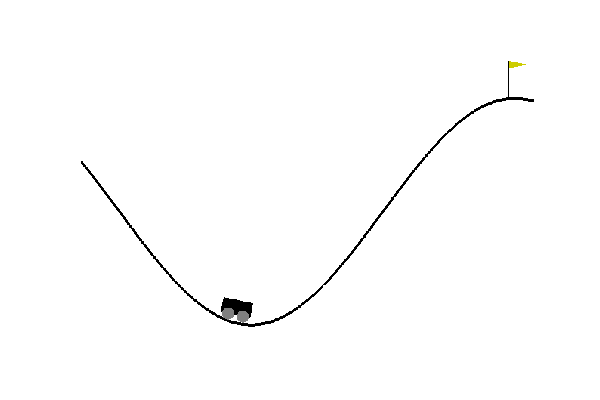
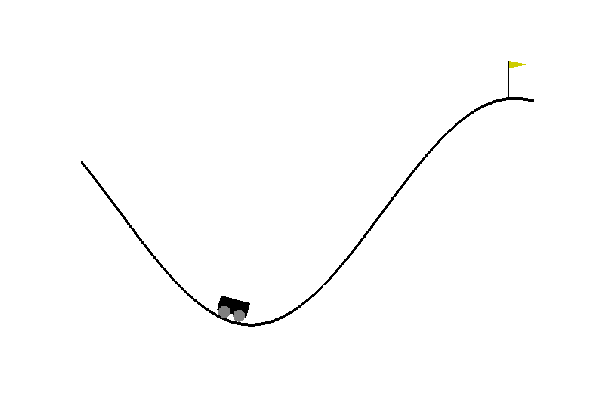
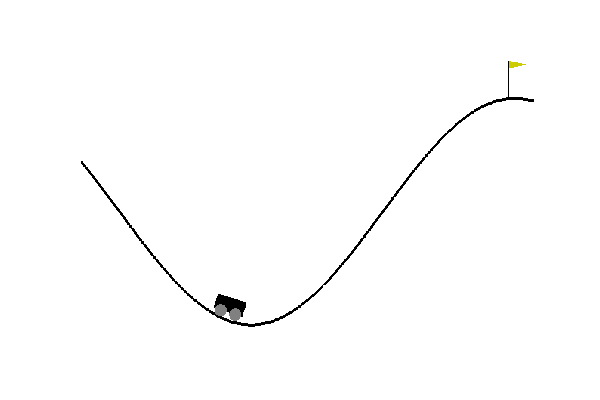
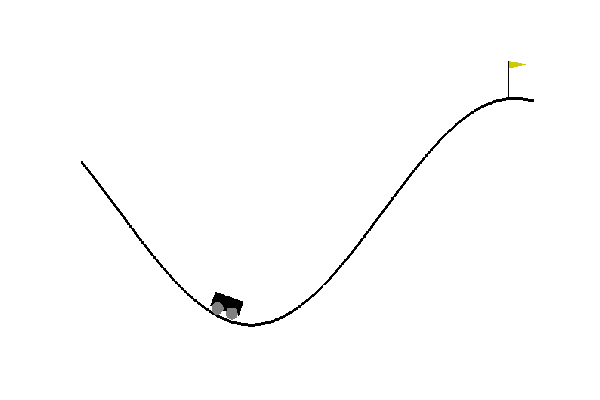
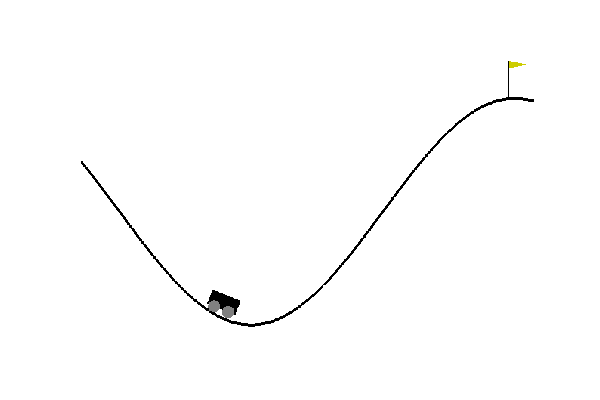
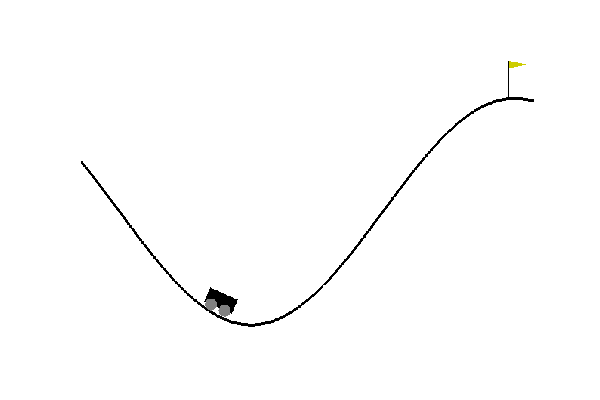
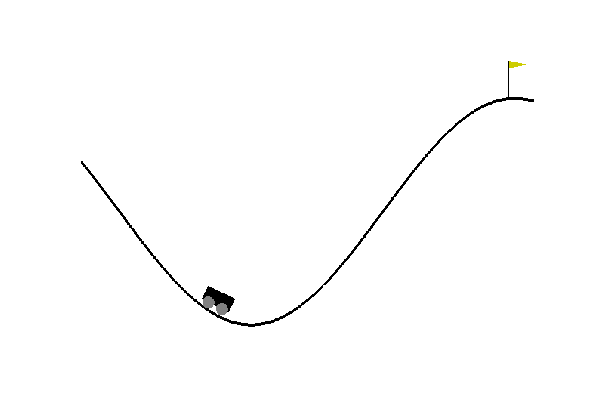
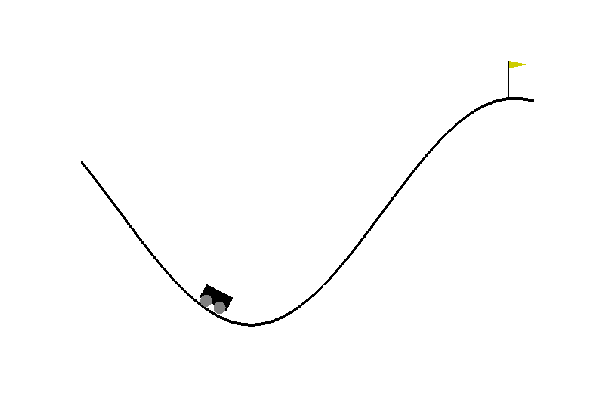
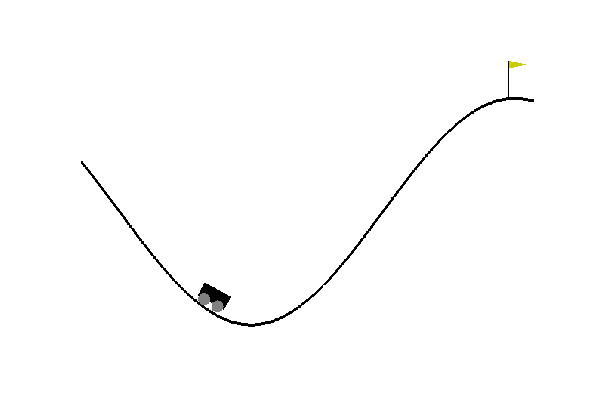
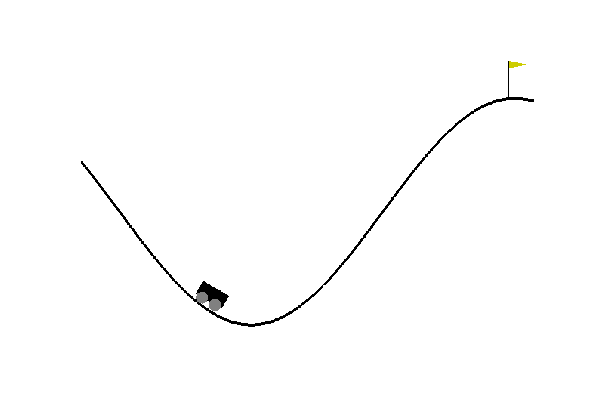
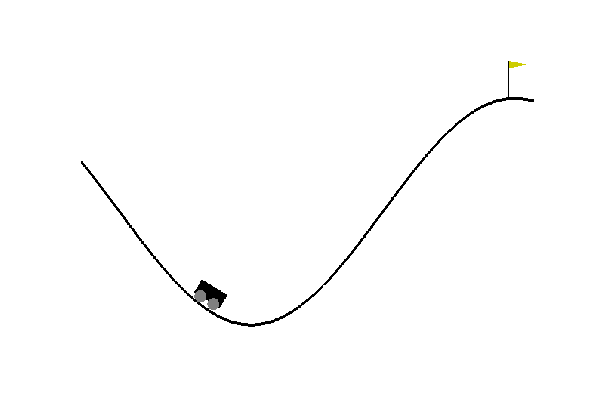
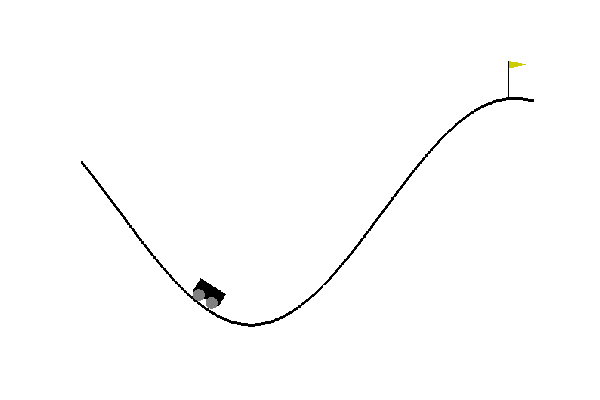
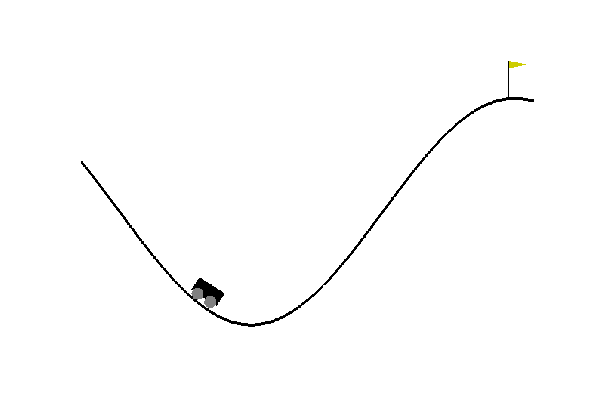
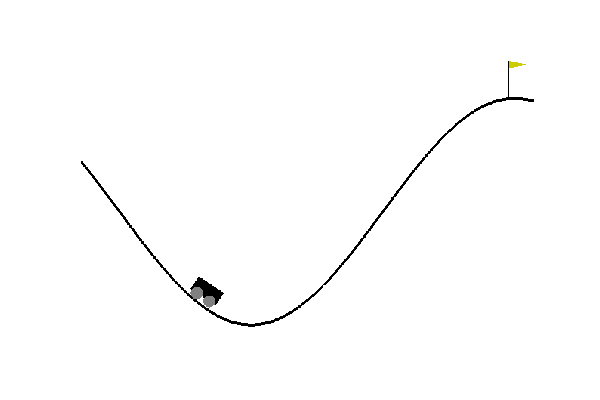
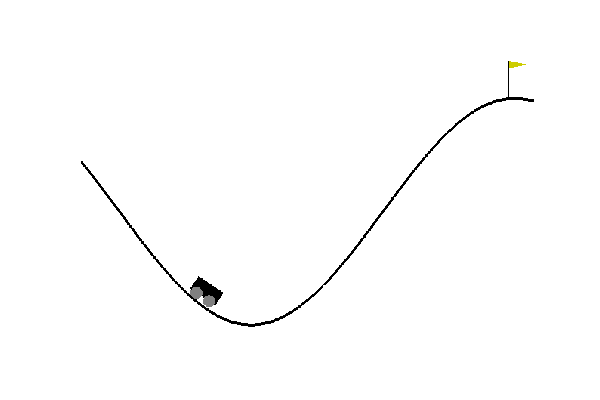
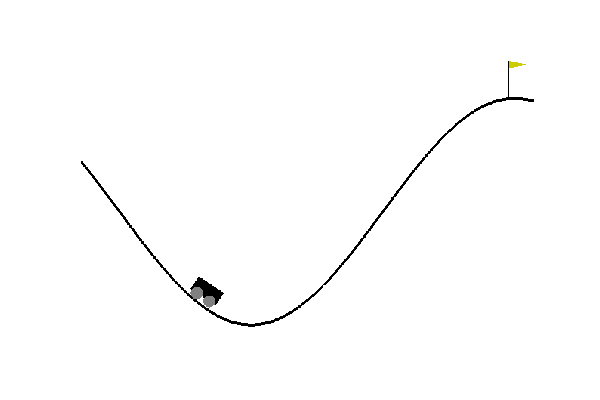
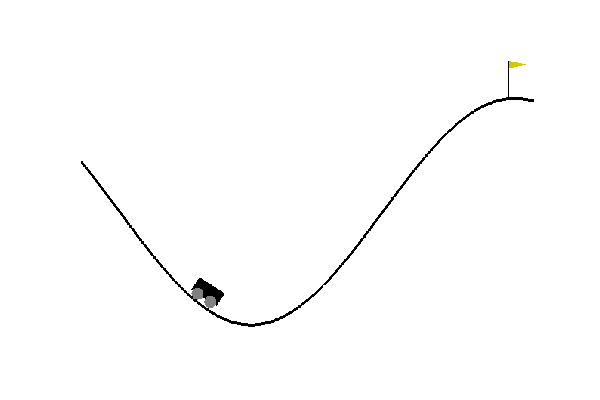
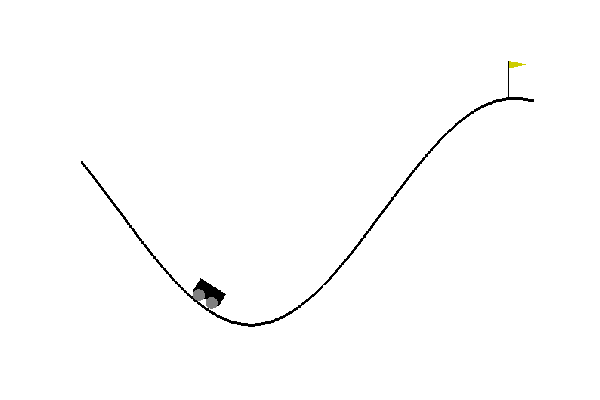
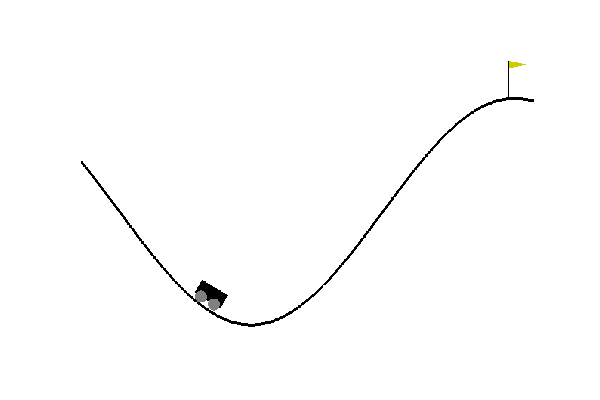
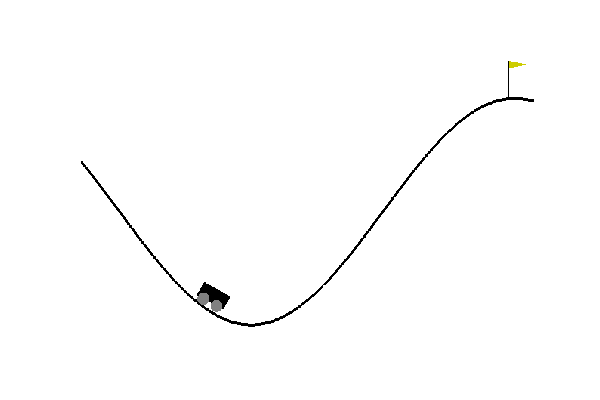
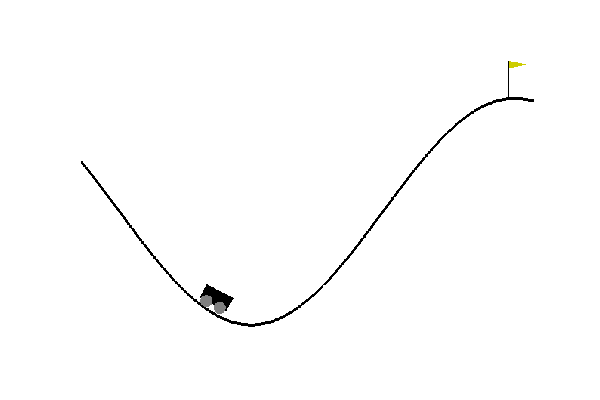
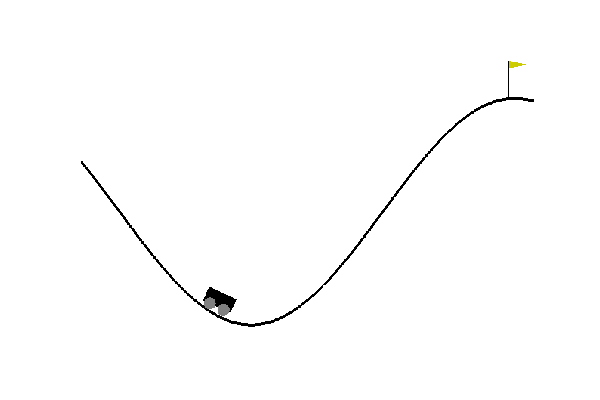
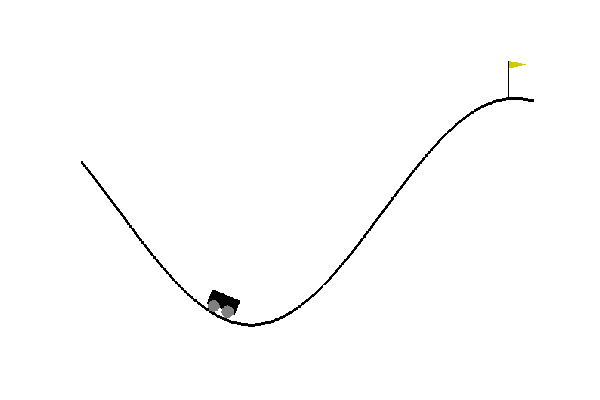
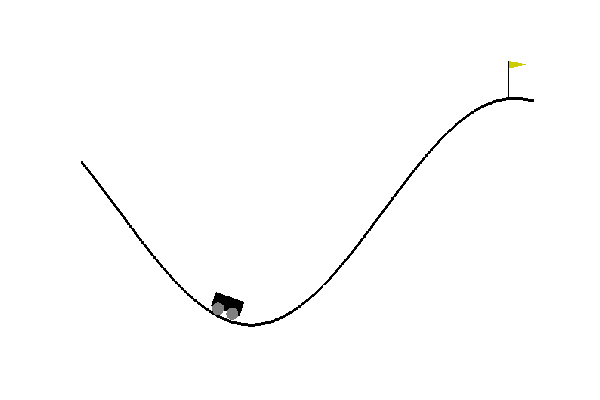
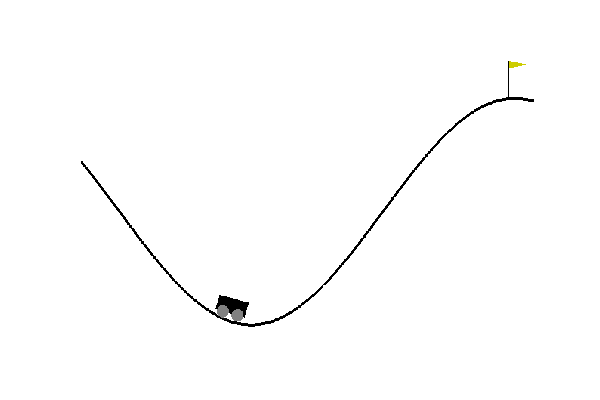
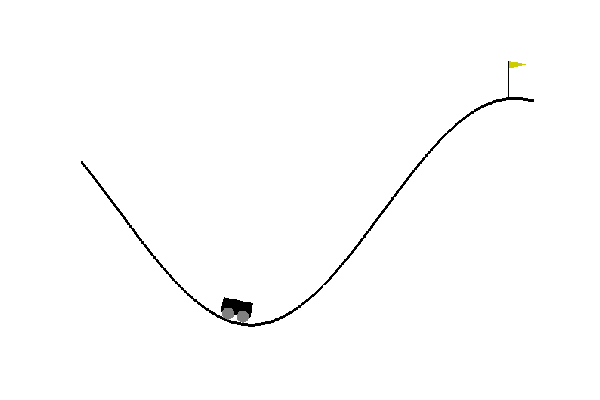
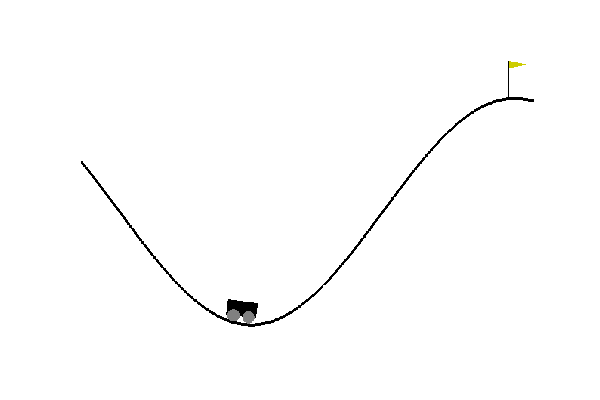
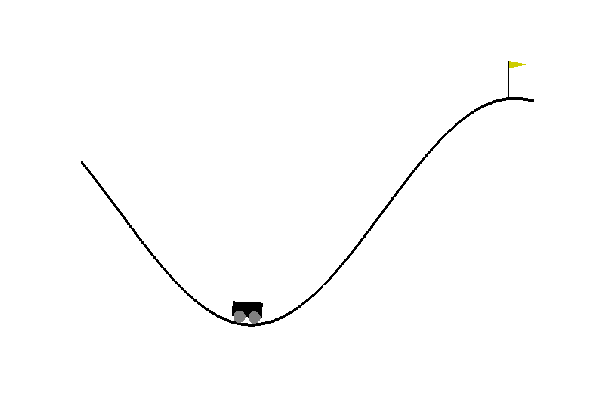
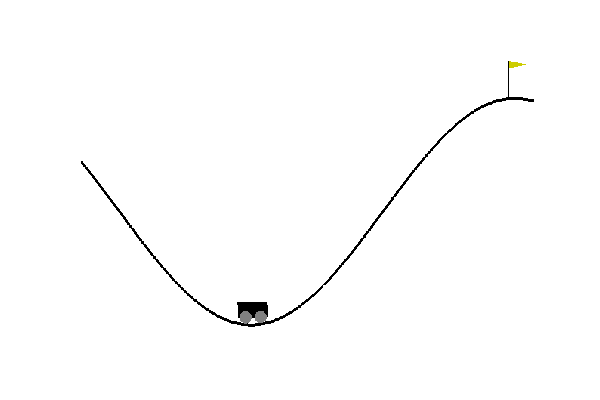
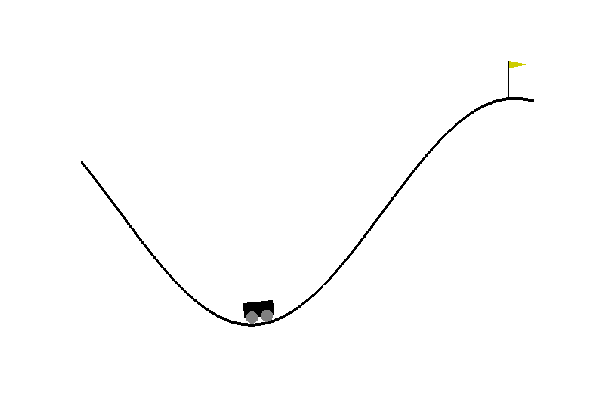
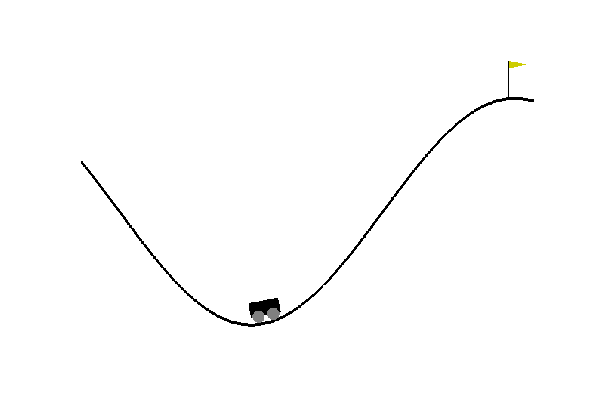
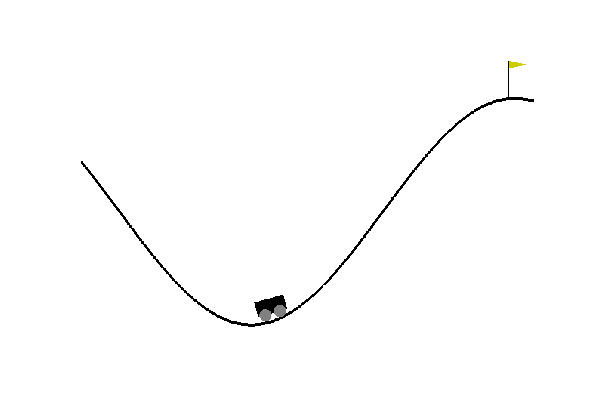
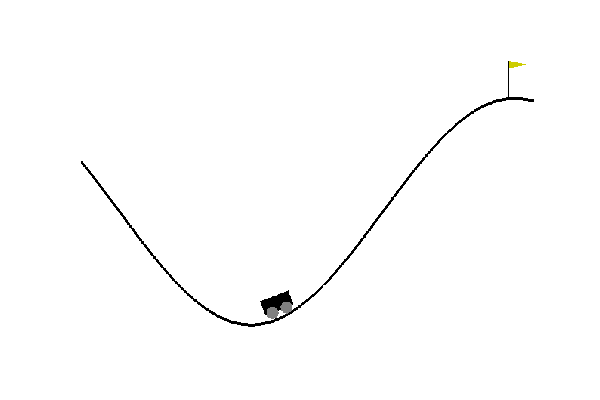
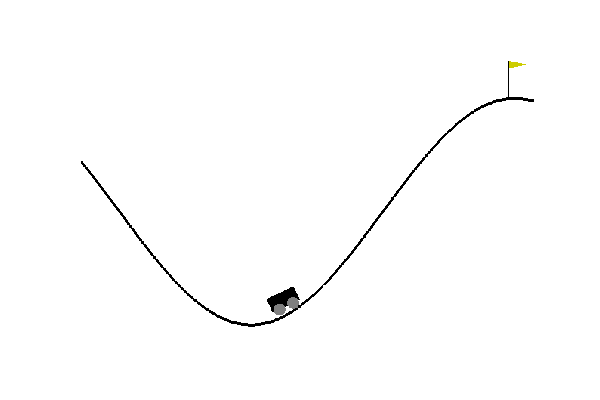
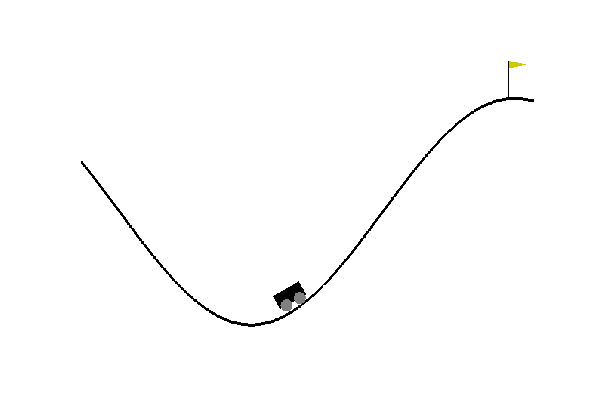
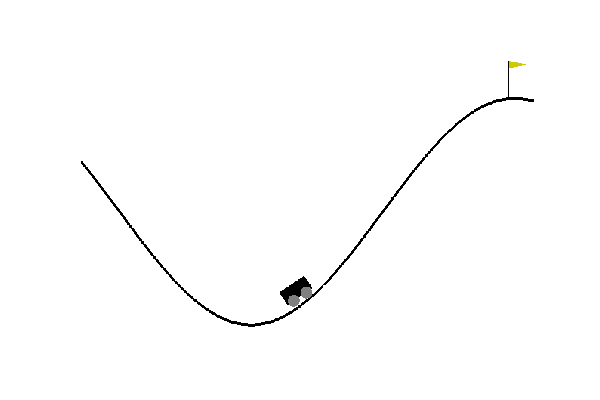
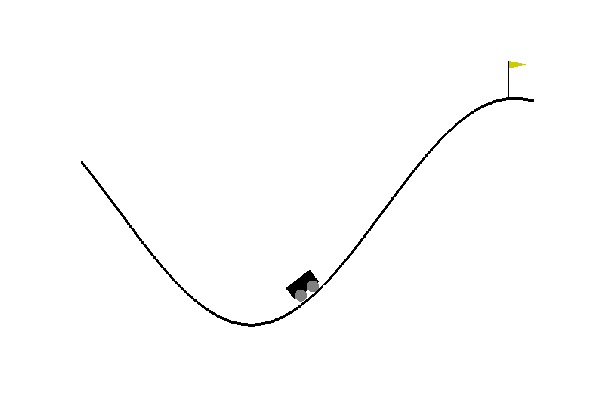
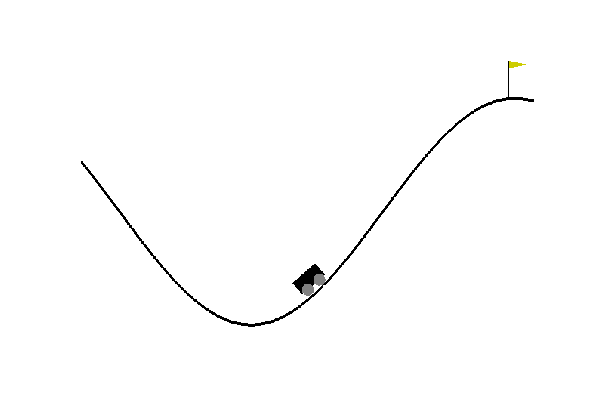
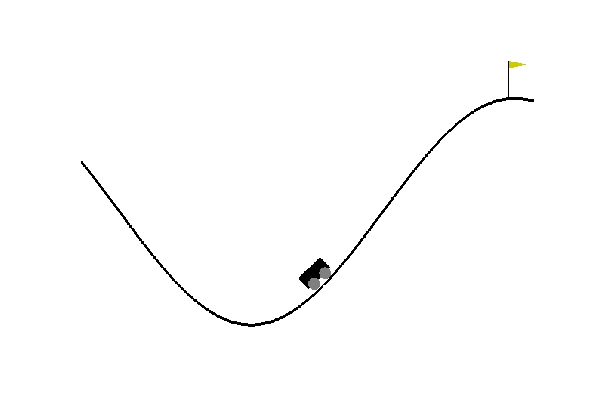
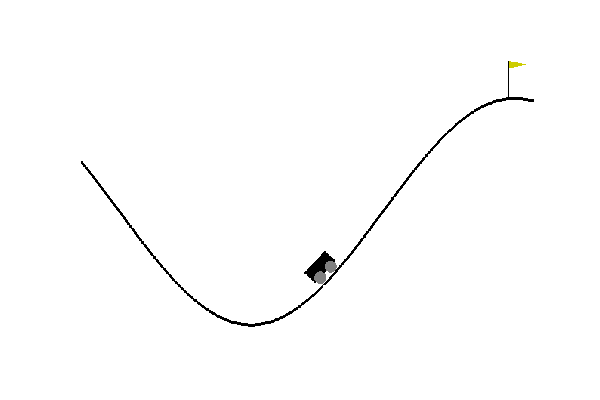
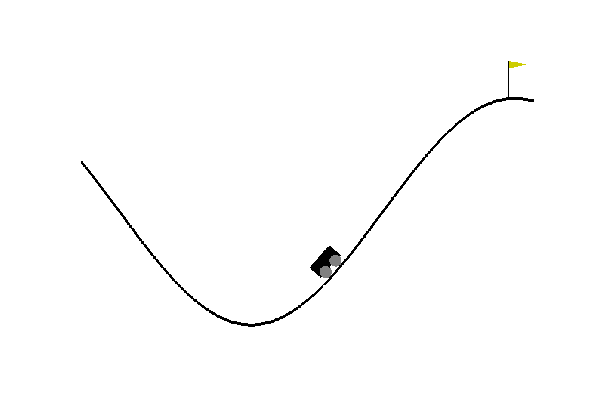
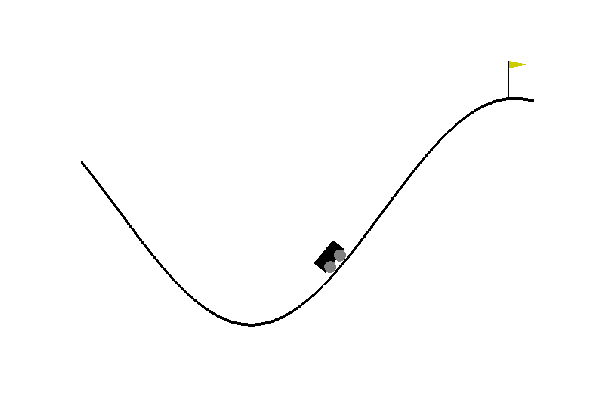
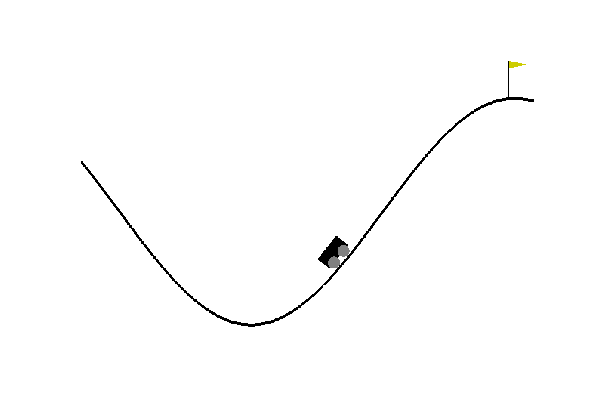
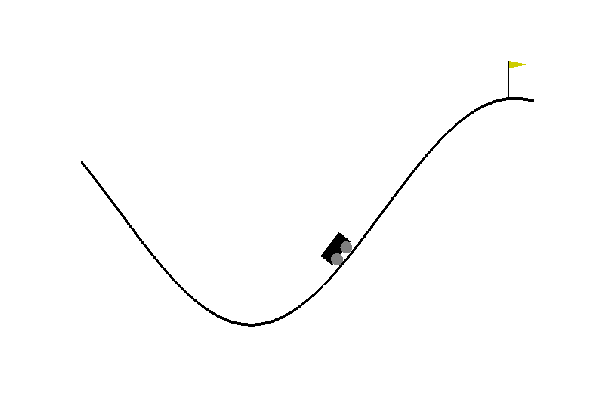
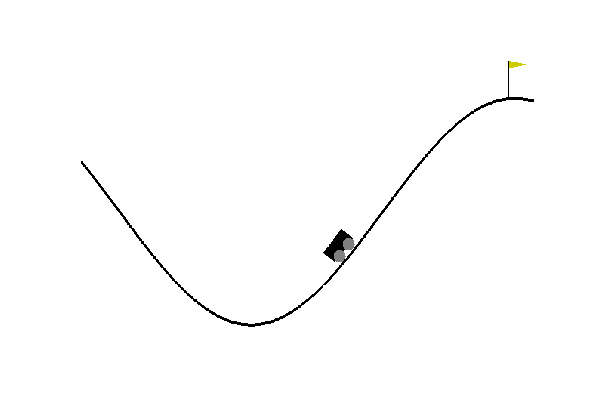
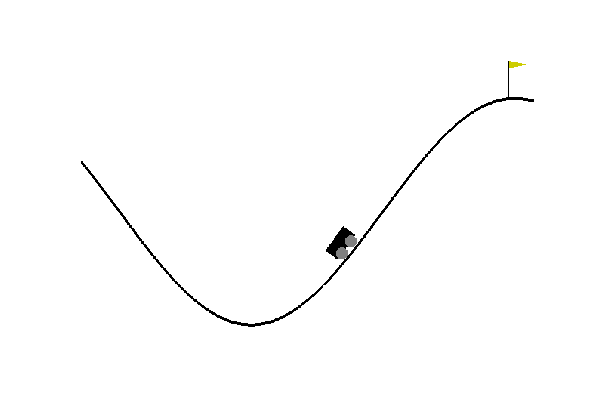
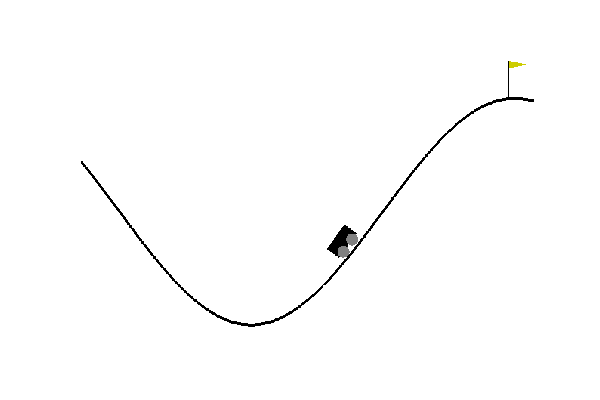
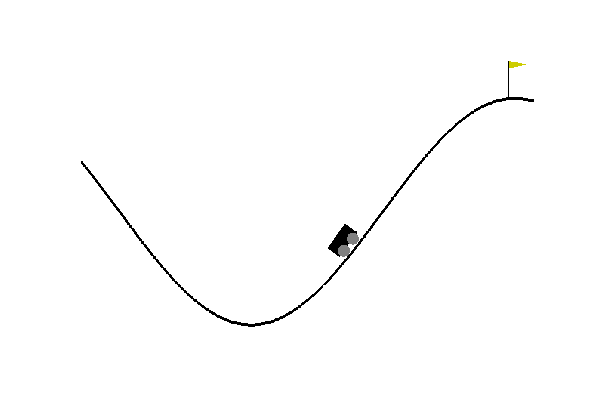
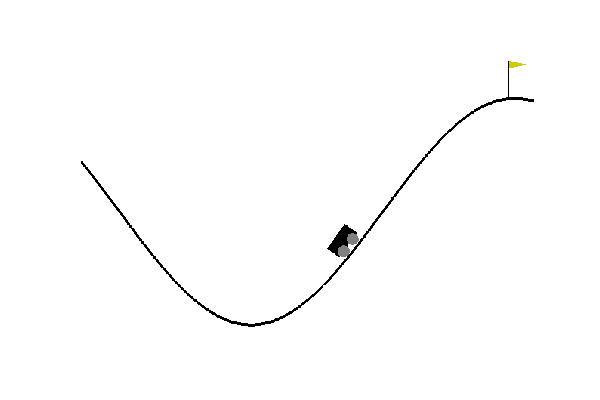
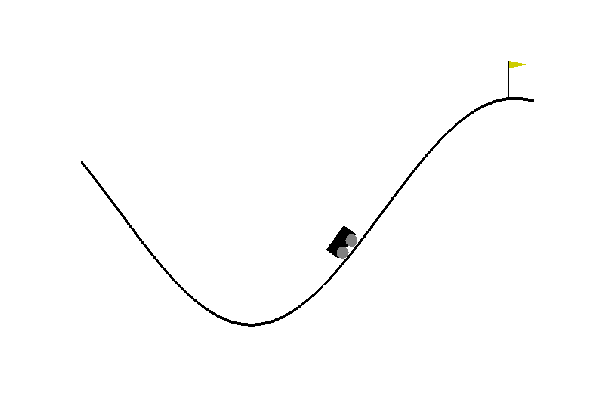
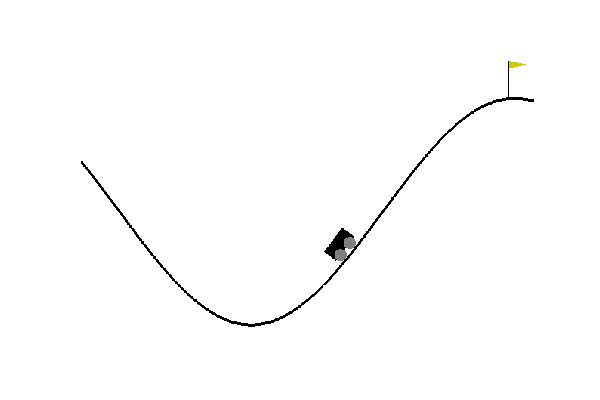
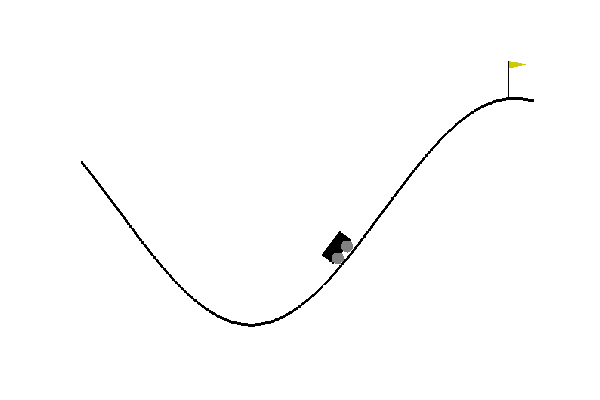
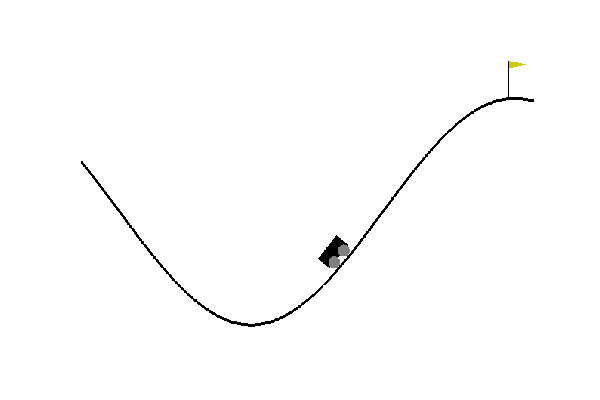
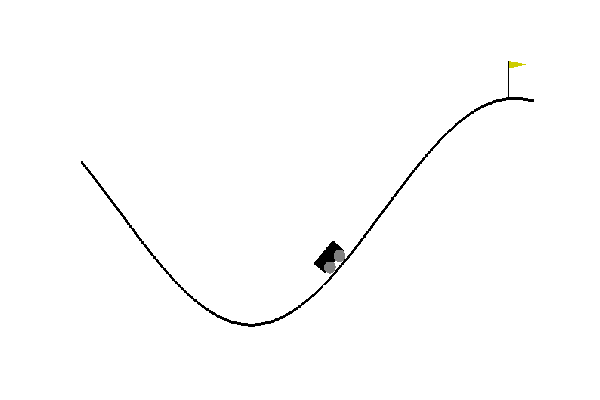
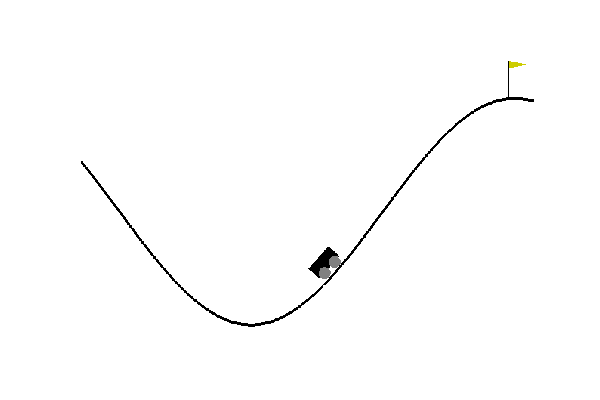
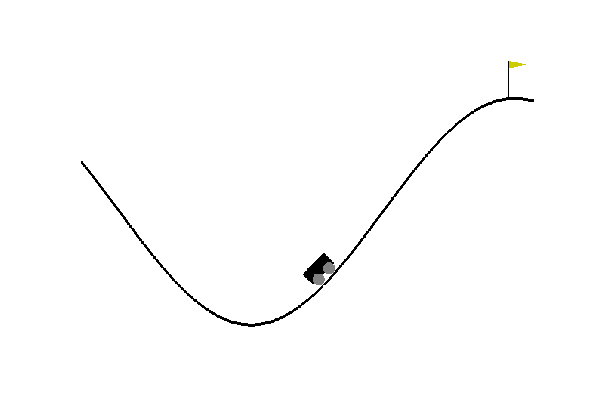
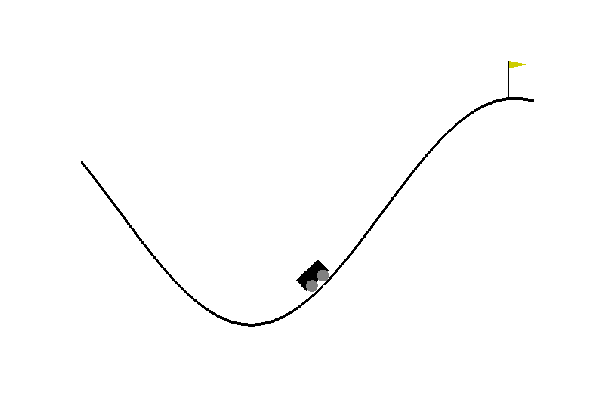
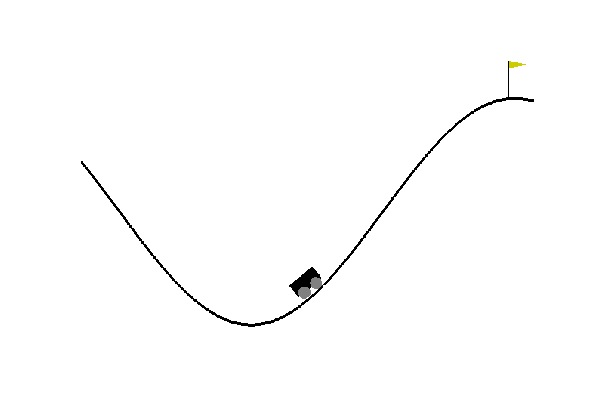
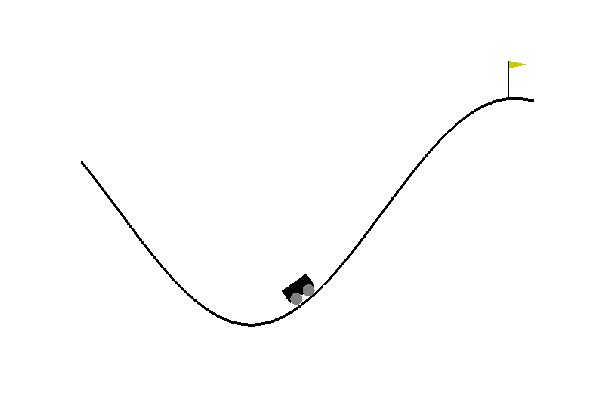
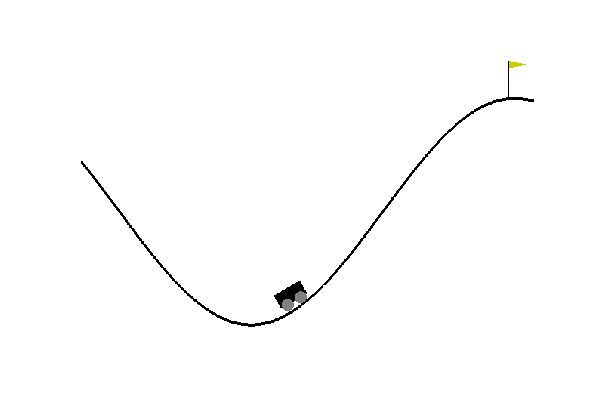
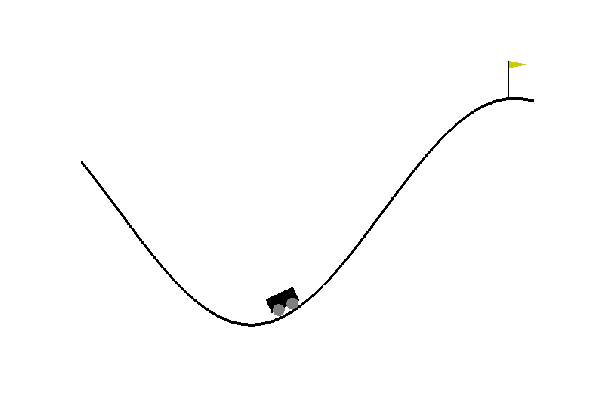
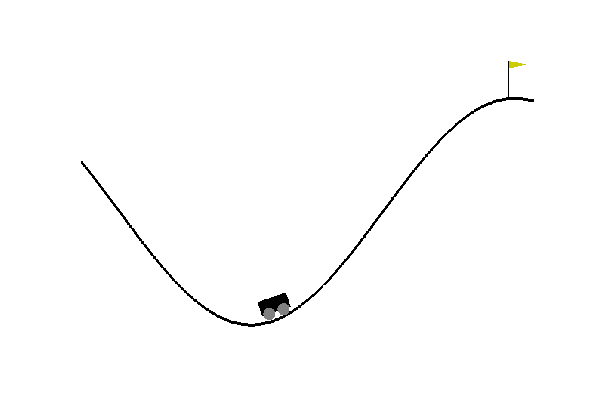
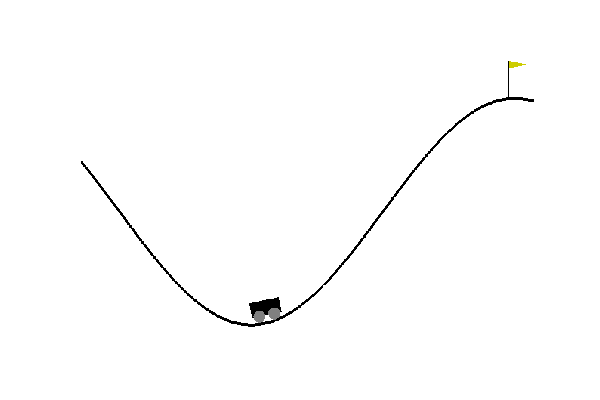
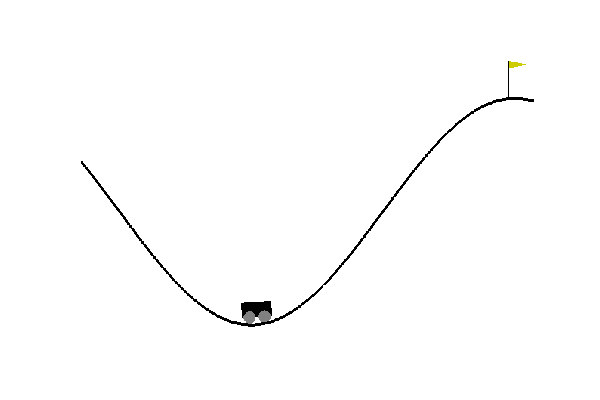
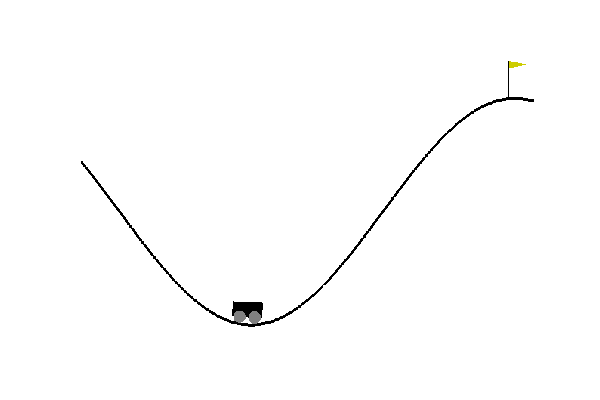
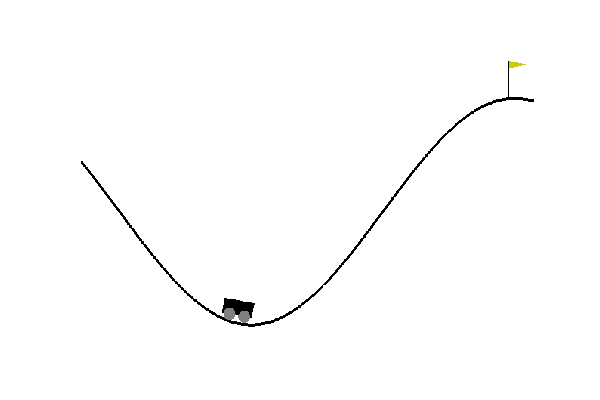
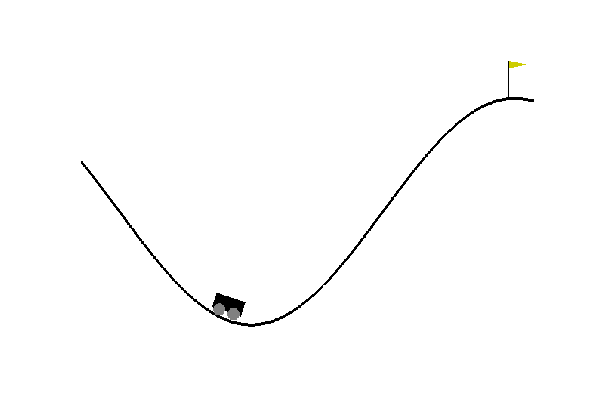
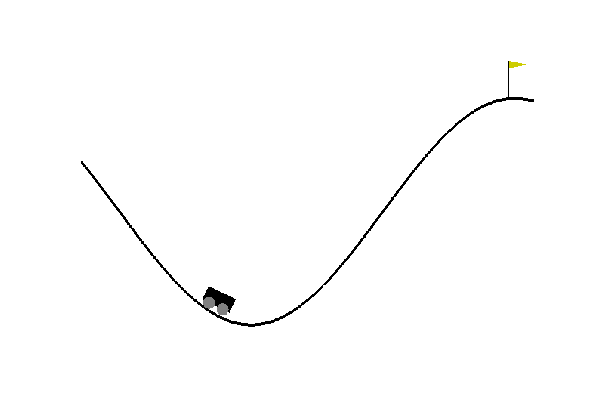
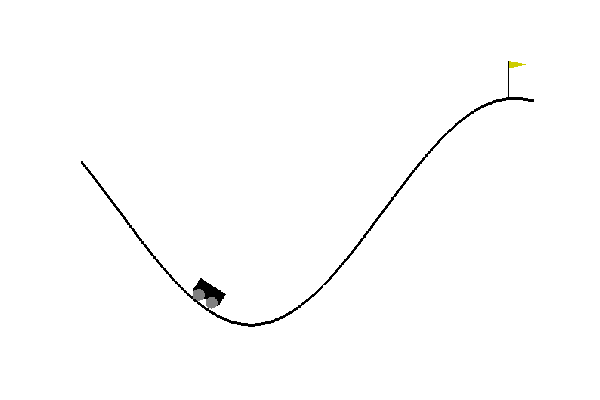
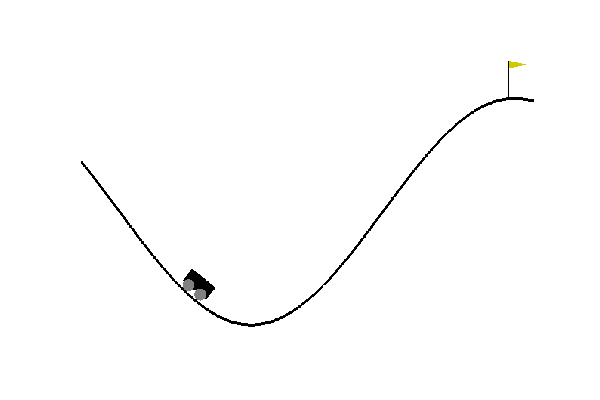
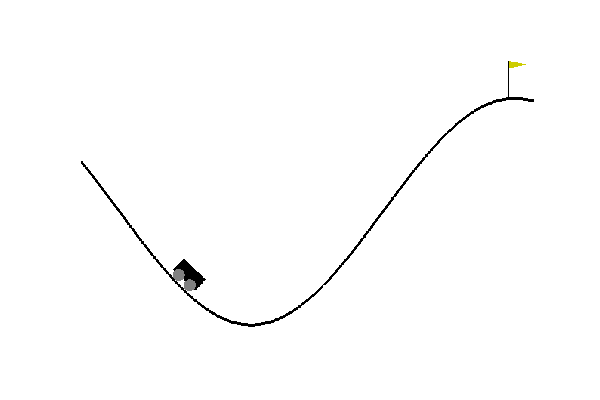
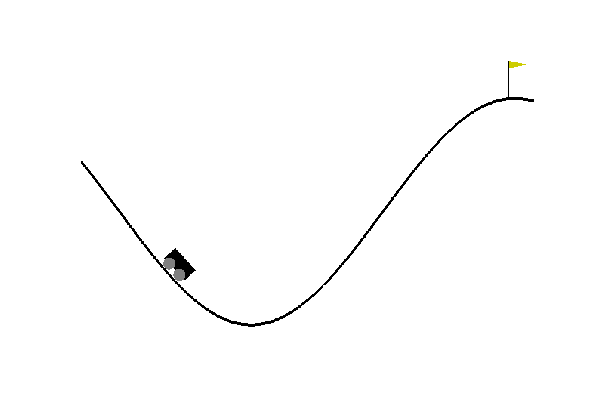
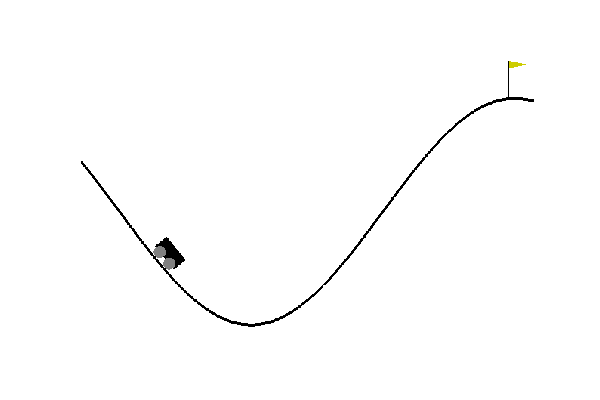
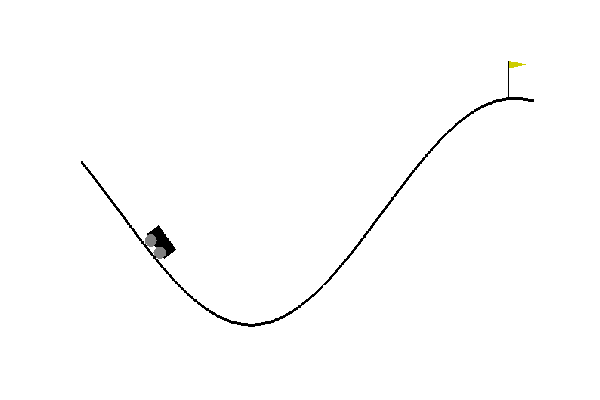
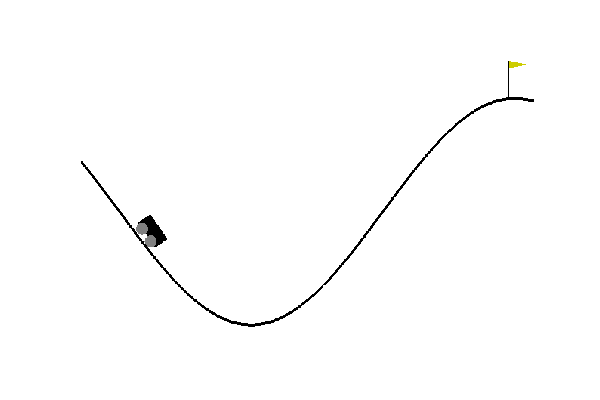
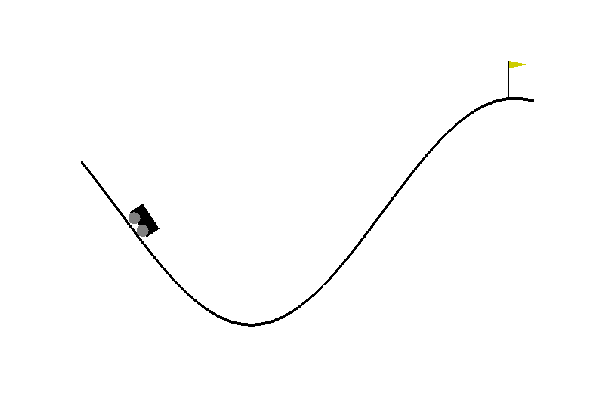
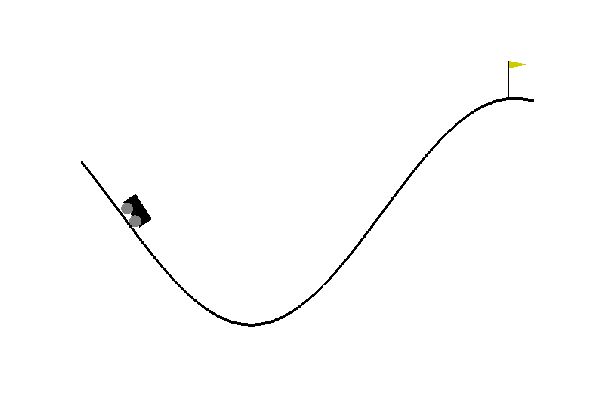
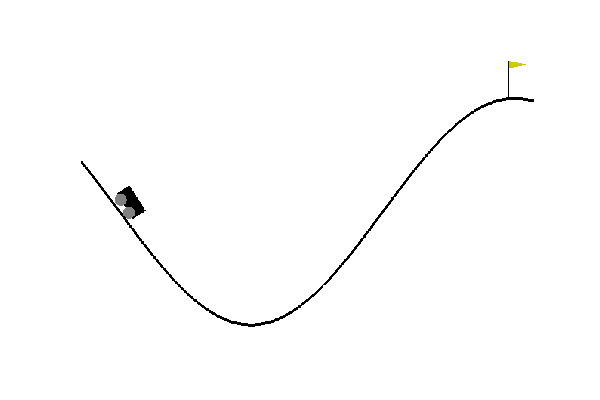
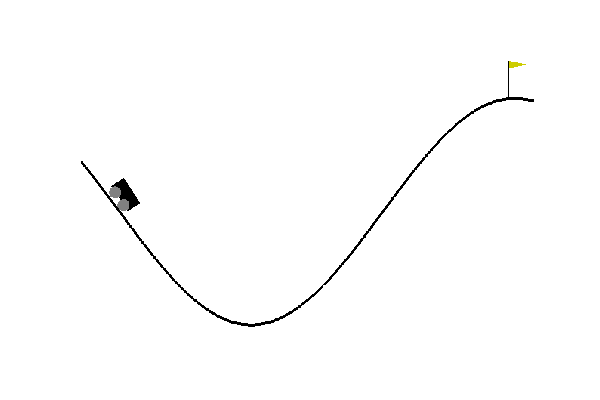
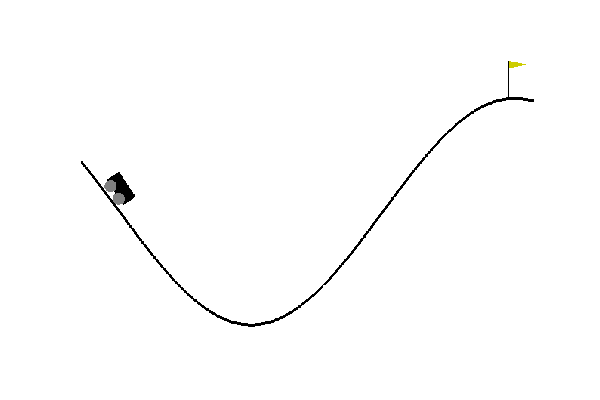
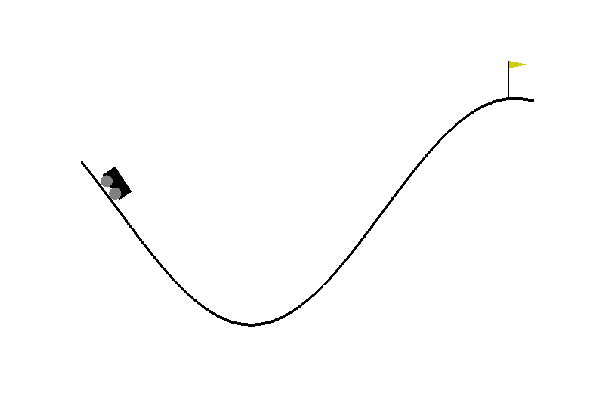
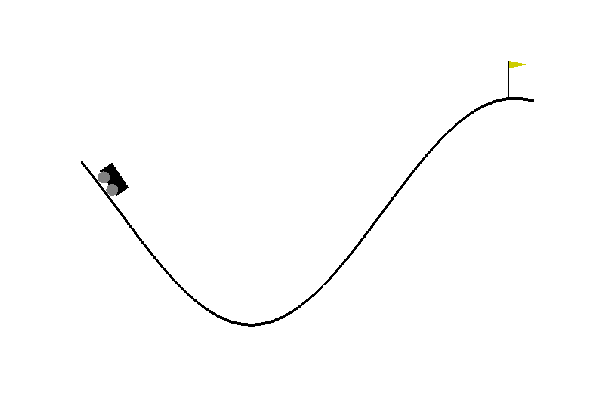
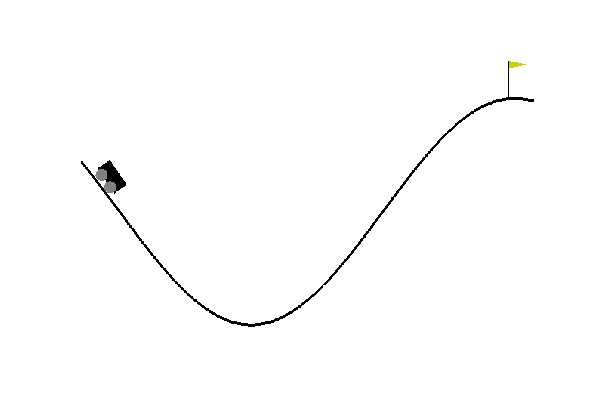
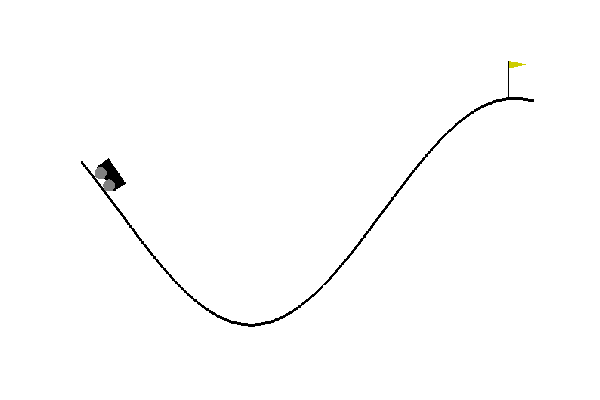
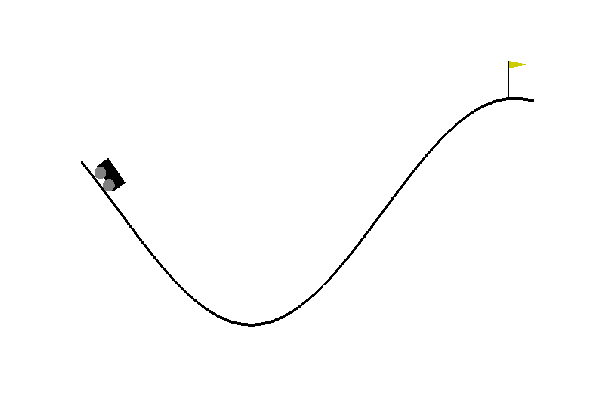
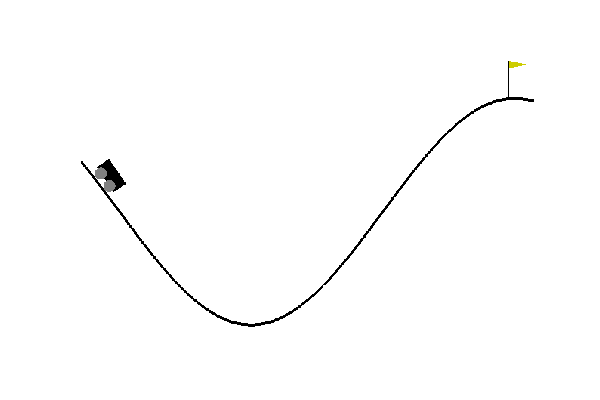
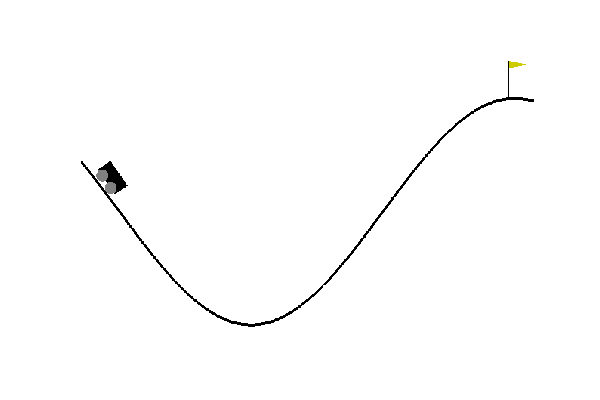
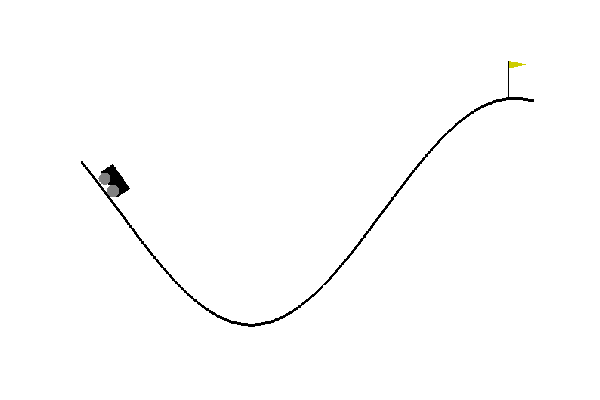
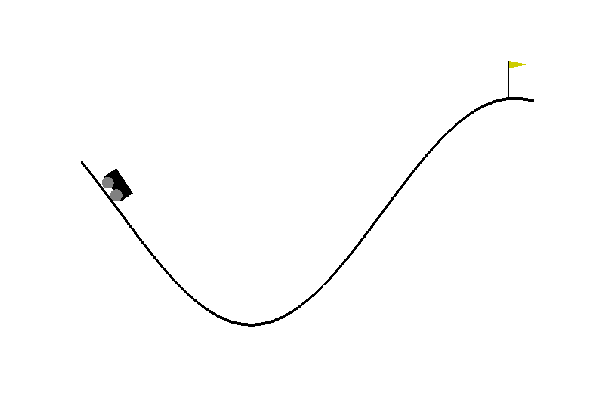
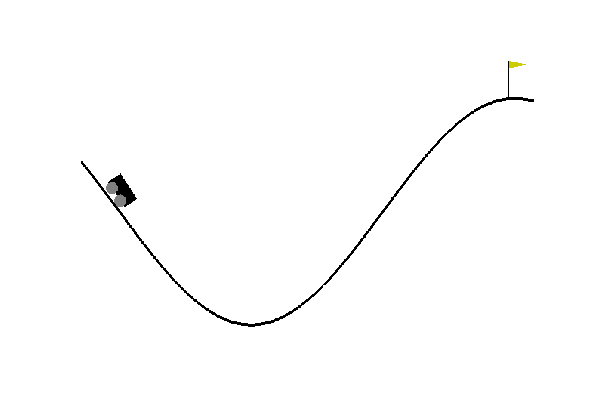
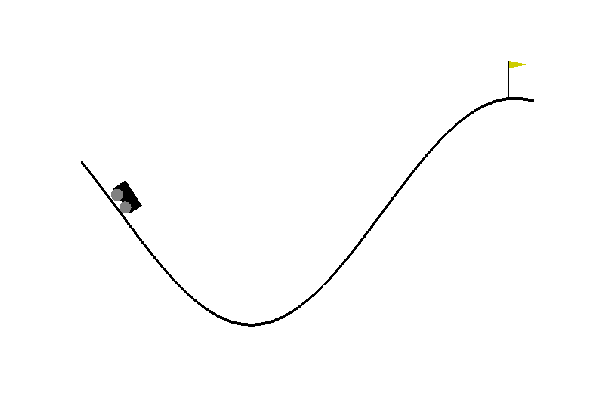
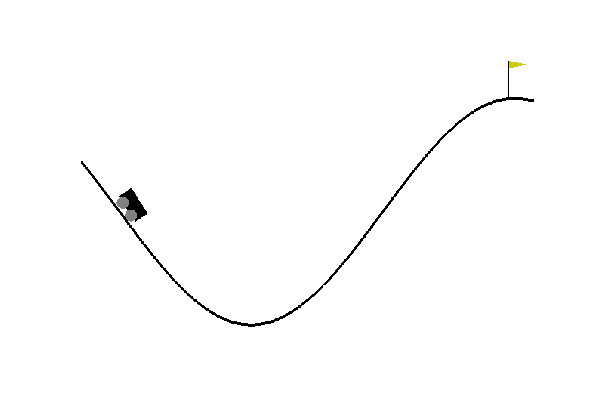
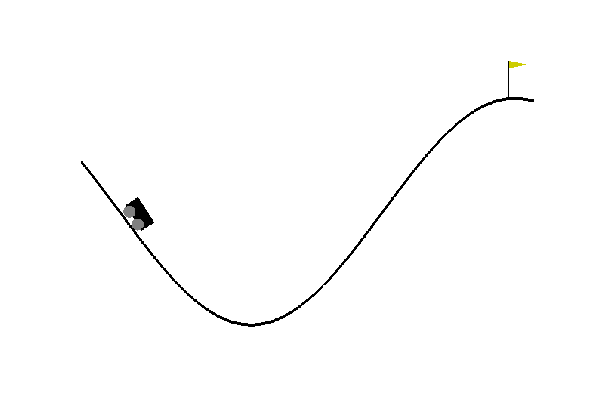
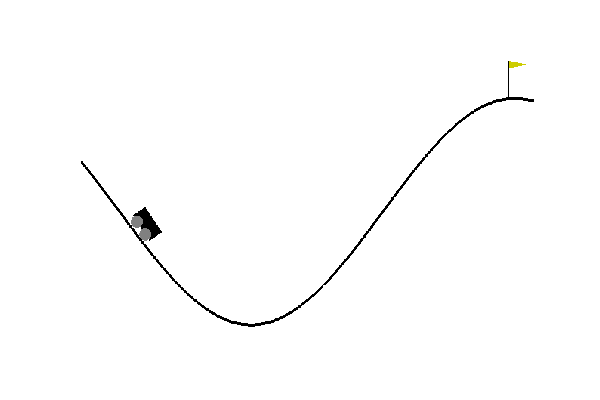
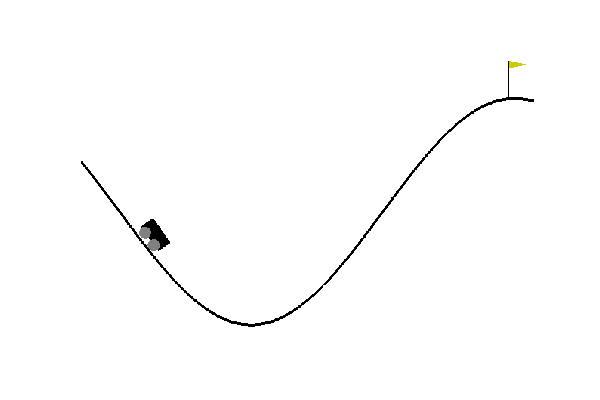
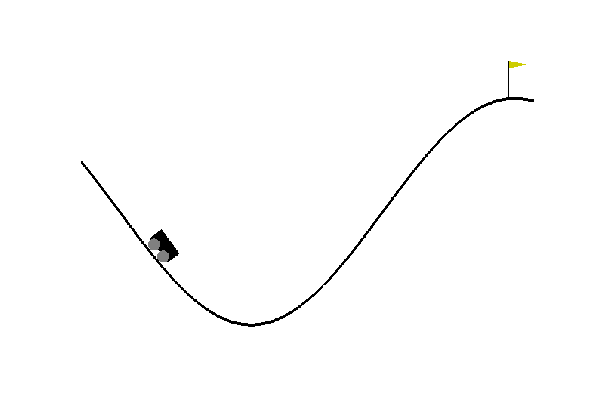
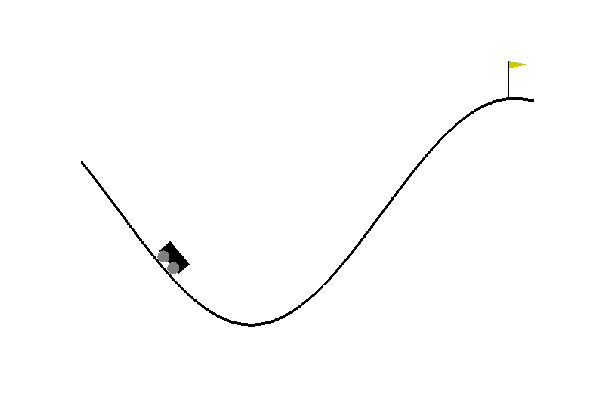
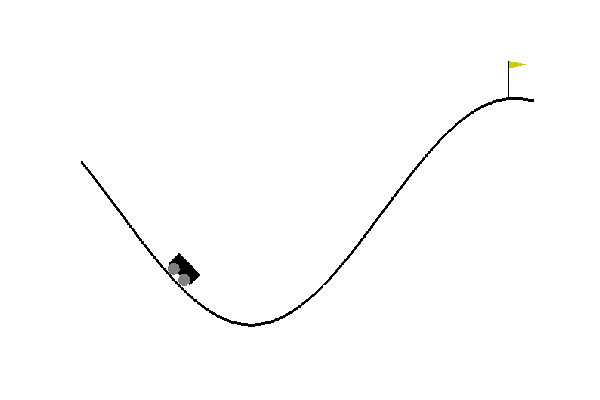
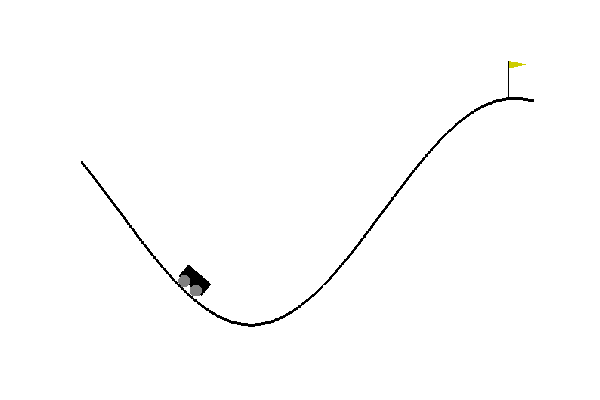
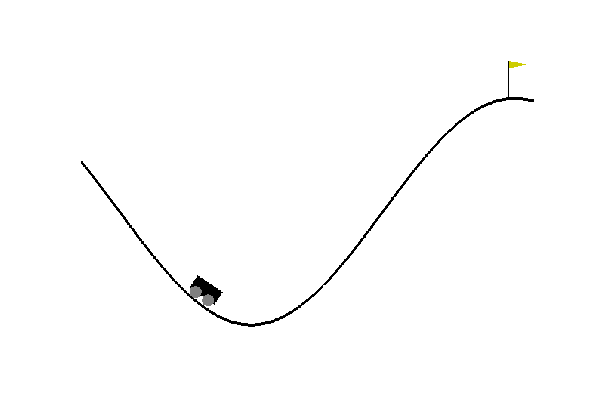
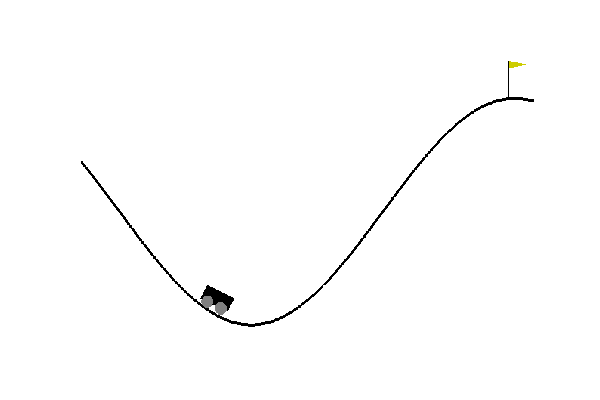
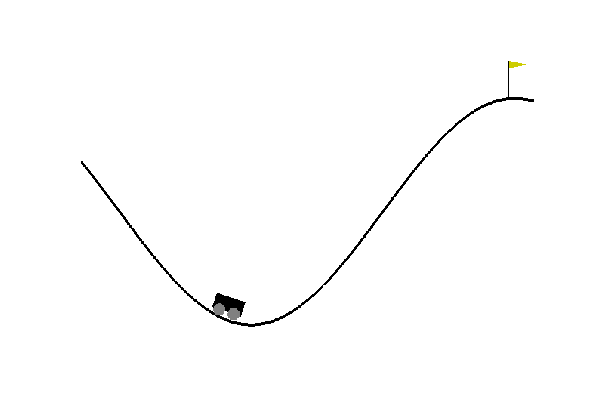
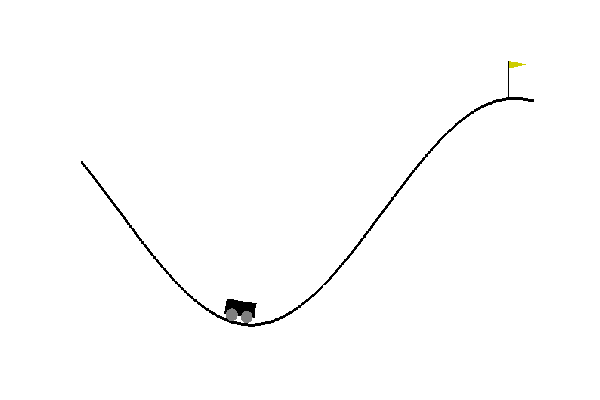
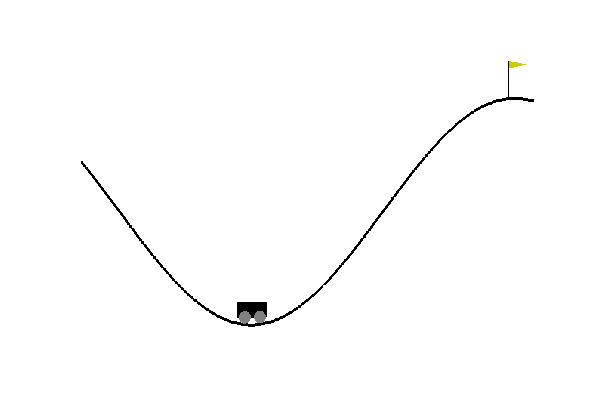
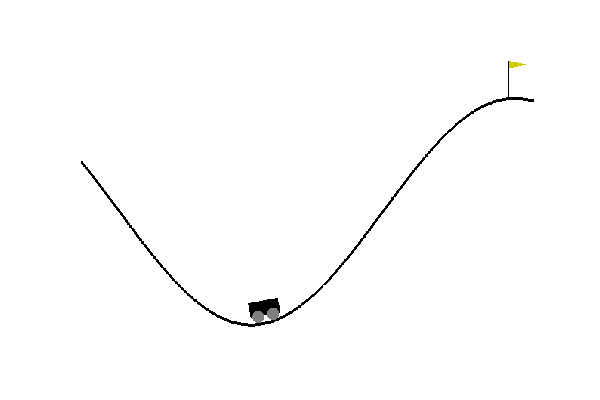
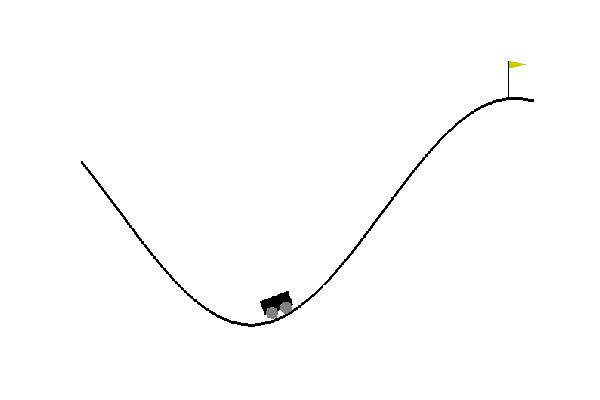
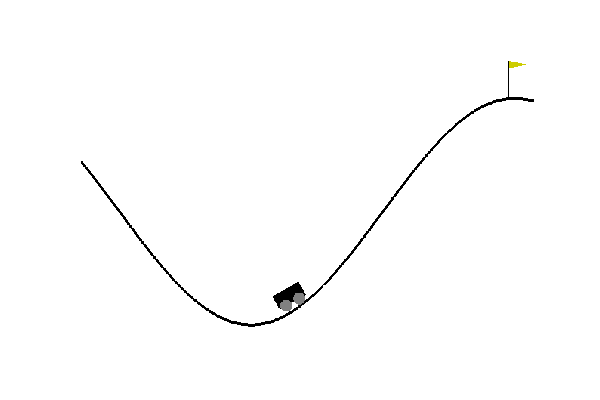
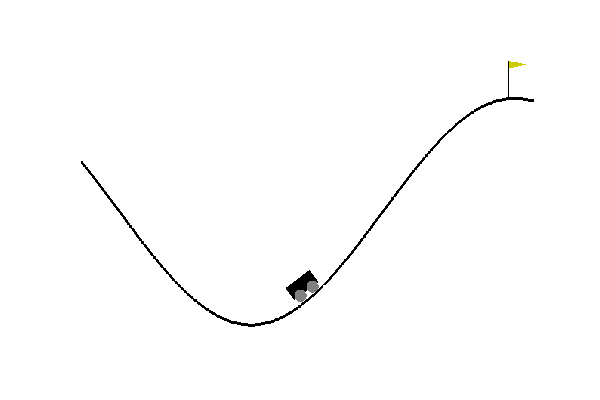
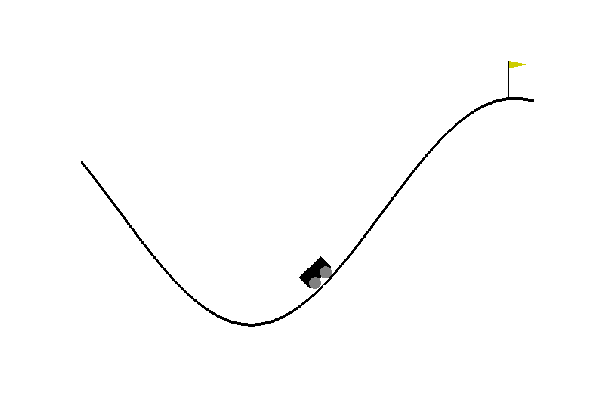
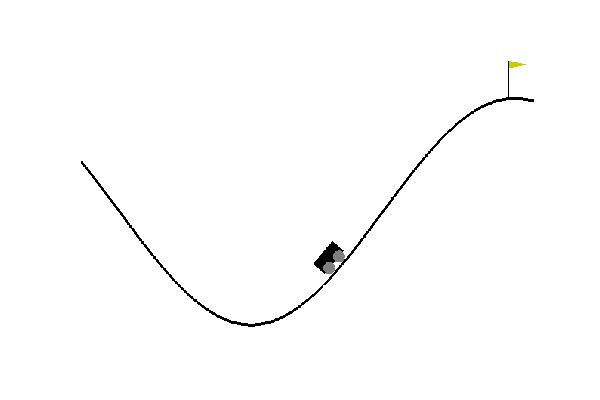
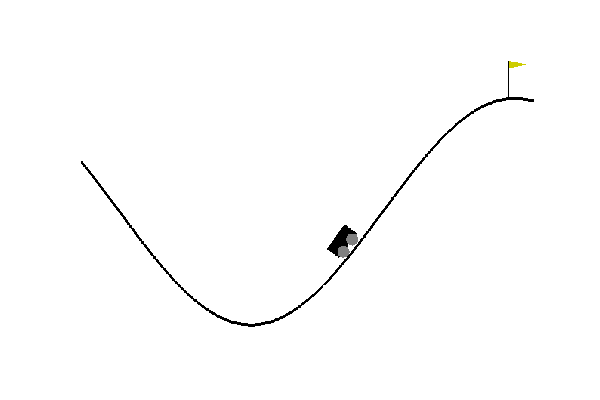
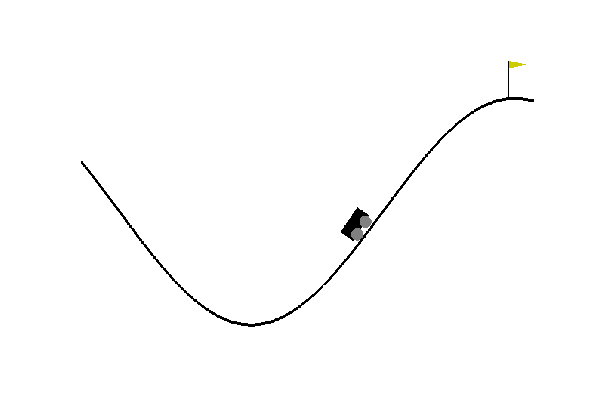
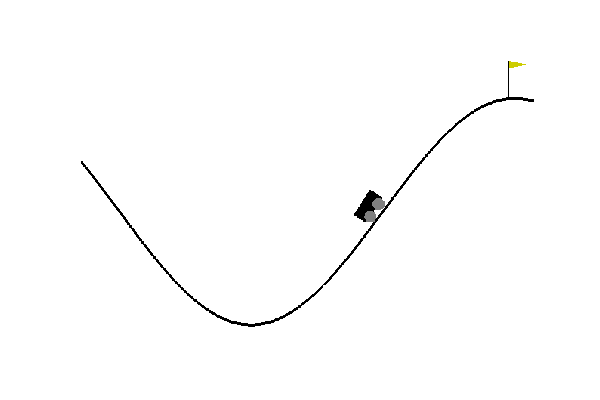
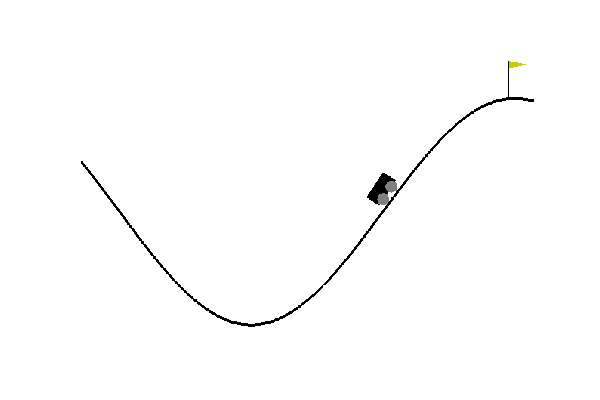
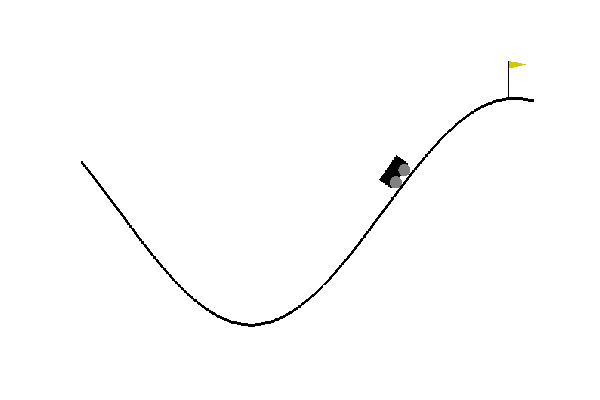
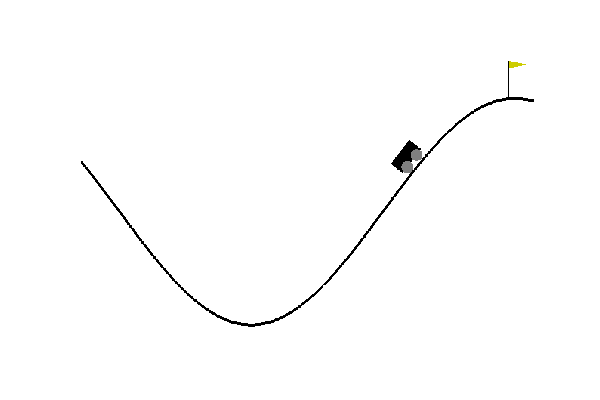
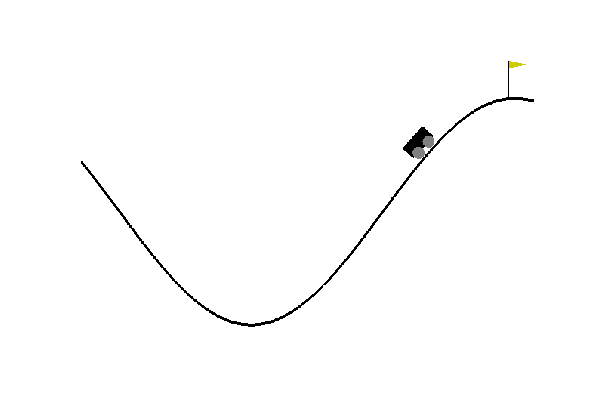
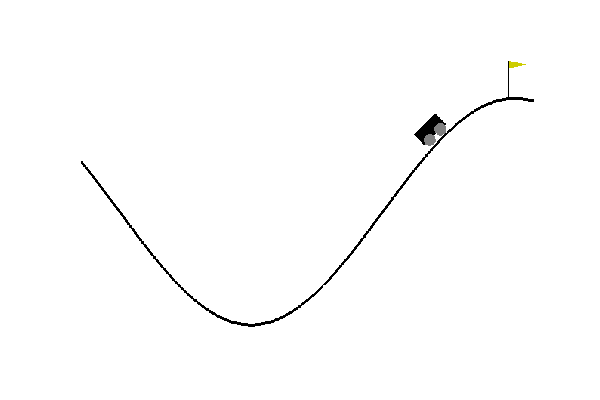
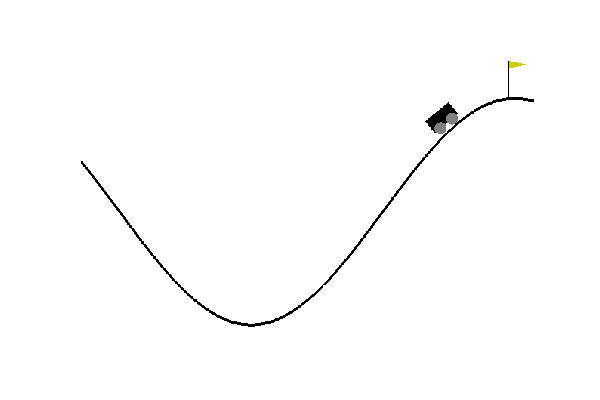
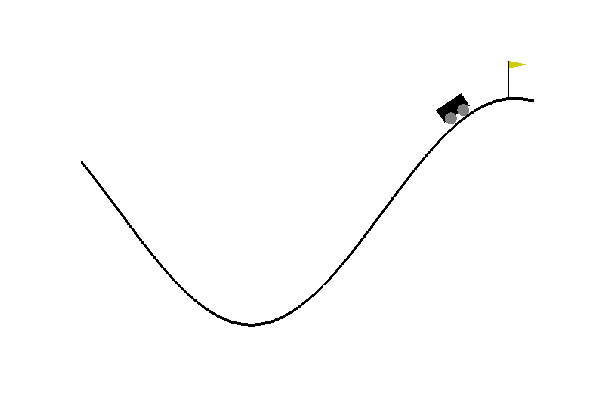
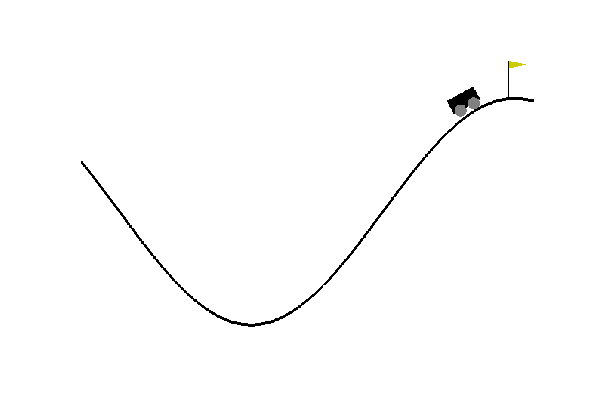
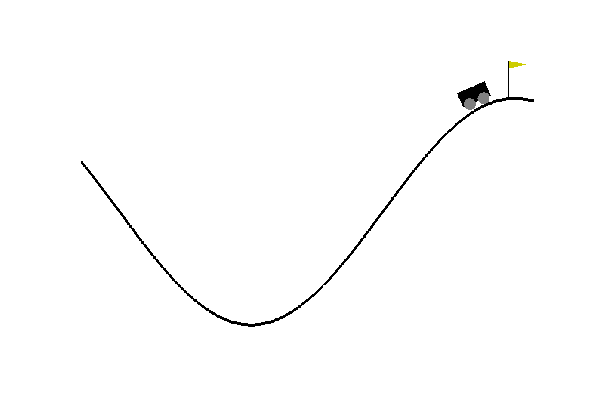
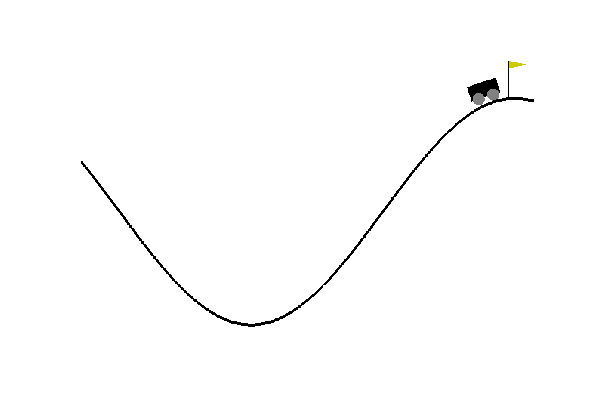
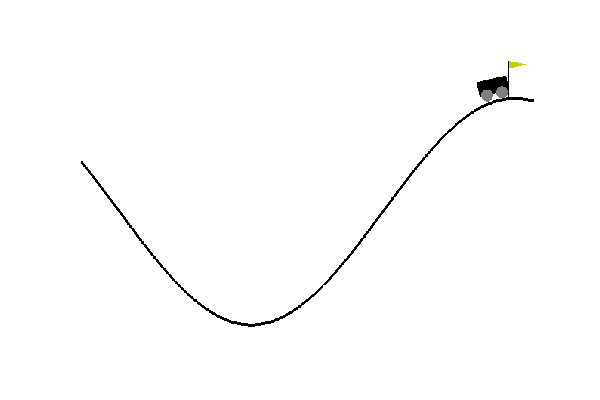
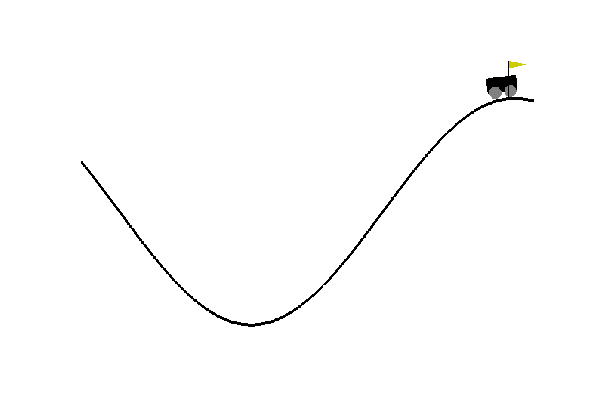

In [26]:
anim = display_frames_as_gif(frames)

In [27]:
save_animation(anim, savepath='policy_gradient_mountaincar.mp4')

Save animation completed
